In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from typing import Generator

In [11]:
def load_file(path) -> pd.DataFrame:
    """Загружает данные из exel файла, удаляет незаполненные значения, формирует колонку временной метки"""
    
    df = pd.read_excel(path, header=0)
    df['DateTime']= pd.to_datetime(df['Date'].astype(str)+' '+ df['Time'].astype(str))
    df = df.drop(['Date', 'Time'], axis=1)
    df.replace('-',np.NaN, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    return df

def replace_outliers(df: pd.DataFrame, chunk_size: int, threshold: float) -> pd.DataFrame:
    filtered_data = df.copy()

    # Итерируемся по столбцам DataFrame
    for column in df.columns:
        # Пропускаем столбец с датой и временем
        if column == df.index.name or column == 'Расход нафты ККР на установку'or column == 'DateTime':
            continue

        # Разделяем столбец на блоки размером chunk_size
        chunks = [df[column].iloc[i:i + chunk_size].copy() for i in range(0, len(df), chunk_size)]
        
        # Вычисляем среднее значение для каждого блока
        averages = [chunk.mean() for chunk in chunks]
        averages = pd.Series(averages)

        # Вычисляем границы значения на основе порога threshold
        lower_bound = np.percentile(averages, threshold)
        upper_bound = np.percentile(averages, 100 - threshold)

        # Если все значения средних являются пустыми, пропускаем столбец
        if averages.isnull().all():
            continue

        # Заменяем значения в блоках, которые выходят за границы
        for i, avg in averages.items():
            if avg < lower_bound or avg > upper_bound:
                start_index = i * chunk_size
                end_index = (i + 1) * chunk_size
                filtered_data.loc[start_index:end_index, column] = np.nan
    
    # Применяем линейную интерполяцию и заполняем пропущенные значения
    for column in filtered_data.columns:
        if column != df.index.name:
            filtered_data[column] = filtered_data[column].interpolate(method='linear')
            filtered_data[column].fillna(method='ffill', inplace=True)
            filtered_data[column].fillna(method='bfill', inplace=True)

    return filtered_data

def plot_timedelta_distr(df: pd.DataFrame, name=None) -> None:
    """Рисует гистограмму распределения временными промежутками между соседними измерениями"""
    
    delta_arr = []
    for i in range(1, len(df)):
        delta_arr.append(df.iloc[i, -1] - df.iloc[i-1, -1])
    print(Counter(delta_arr), '\n')
    hist_arr = [i.total_seconds()/60 for i in delta_arr]
    plt.hist(hist_arr,)
    plt.xlabel("Величина промежутка между измерениями, мин")
    plt.ylabel("Количество промежутков")
    if name is not None:
        plt.title(name)
    plt.show()


def construct_XY(df_X: pd.DataFrame, df_Y: pd.DataFrame, max_diff: pd.Timedelta, diff2: pd.Timedelta) -> Generator[np.ndarray, np.ndarray, pd.Timestamp]:
    """Формирует генератор точек X и Y, каждому Y соответствует несколько X во временном промежутке"""
    
    num = 0
    Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
    X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
    for i in range(len(df_X)):
        timeX = df_X.iloc[i, -1]
        timeY = df_Y.iloc[num, -1]
        if timeX > timeY:
            if timeX - timeY > max_diff:
                tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
                X = np.vstack((X, tmp_X))
            yield X, Y, timeY
            num += 1            
            if num >= len(df_Y):
                break
            
            X = np.array([], dtype=np.float64).reshape(0, len(df_X.columns)-1)
            Y = df_Y.iloc[num,:-1].to_numpy(dtype=np.float64)
            continue
        if timeY - timeX > max_diff:
            continue
        tmp_X = df_X.iloc[i, :-1].to_numpy(dtype=np.float64)
        X = np.vstack((X, tmp_X))


def plot_num_distr(gen, name=None) -> None:
    """Рисует гистограмму распрделения количества точек X на одну точку Y"""
    
    shapes = []
    i = 0
    for x, y, _ in gen:
        i += 1
        shapes.append(len(x))
    print(f"Количество точек {i} \n")
    print(f'Распределение количества примеров \n {Counter(shapes)} \n')
    plt.hist(shapes)
    plt.xlabel("Количетсво точек X на одно лабораторное измерение")
    plt.ylabel("Количество записей")
    if name is not None:
        plt.title(name)
    plt.plot()

In [12]:
df_X1 = load_file('Исходные данные/Процессные данные Давление насыщенных паров в продукте, зимний период.xlsx')
df_X2 = load_file('Исходные данные/Процессные данные Конец кипения легкого бензина.xlsx')
df_X3 = load_file('Исходные данные/Процессные данные Содержание олефинов в продукте.xlsx')

In [13]:
filtered_df = replace_outliers(df_X1,50,10)
print(filtered_df)

       Расход бензина ККР на установку  Расход нафты ККР на установку  \
0                                95.63                          32.56   
1                                95.98                          32.80   
2                                95.60                          32.76   
3                                95.72                          32.76   
4                                95.53                          32.80   
...                                ...                            ...   
12884                           103.80                           0.00   
12885                           103.66                           0.00   
12886                           103.14                           0.00   
12887                           103.68                           0.00   
12888                           101.99                           0.00   

       Расход бензина на рециркуляцию от Е-1205  \
0                                          0.00   
1                    

C:\Users\PC\AppData\Local\Temp\ipykernel_14548\496905390.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data[column].fillna(method='ffill', inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_14548\496905390.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data[column].fillna(method='bfill', inplace=True)


In [14]:
import sys

sys.path.append("...")

import Essentials

In [15]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from IPython.display import display
import matplotlib.dates as mdates

In [16]:
def parameter_vis(df):
    num_of_columns = len(df.columns)
    df.set_index('DateTime', inplace = True)
    for i in range(num_of_columns - 1):
        column_data = df.iloc[:, i]
        column_data.plot(y = df.iloc[:, i].name, marker = 'o', linestyle='', markersize=2, linewidth=0.5)
        plt.xticks(rotation=45)
        plt.tick_params(axis='x', labelsize=6)
        plt.title(f'График {df.iloc[:, i].name}')  
        plt.show()

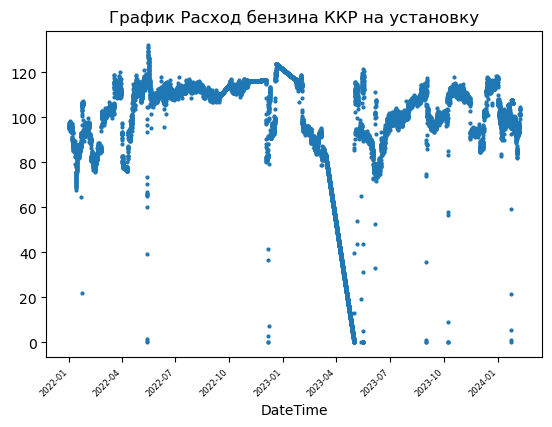

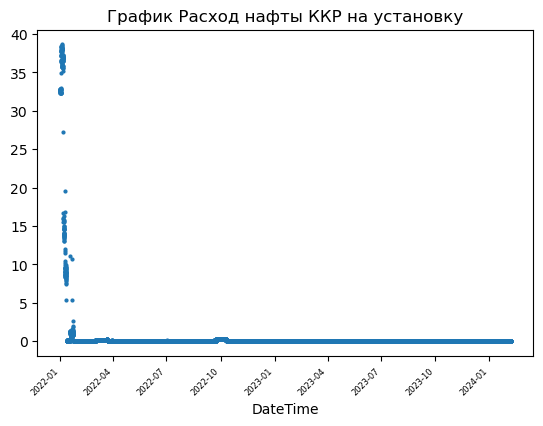

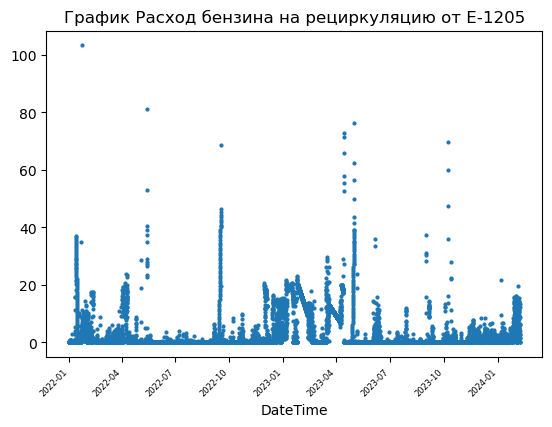

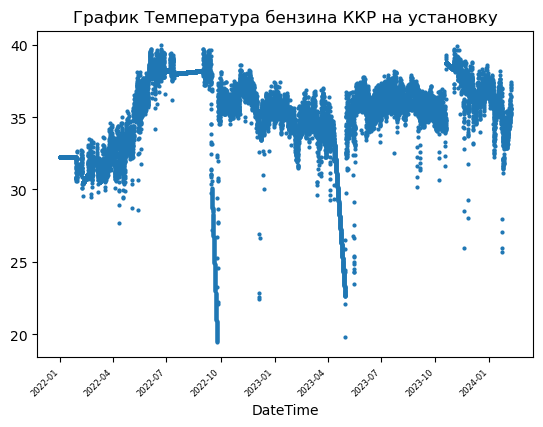

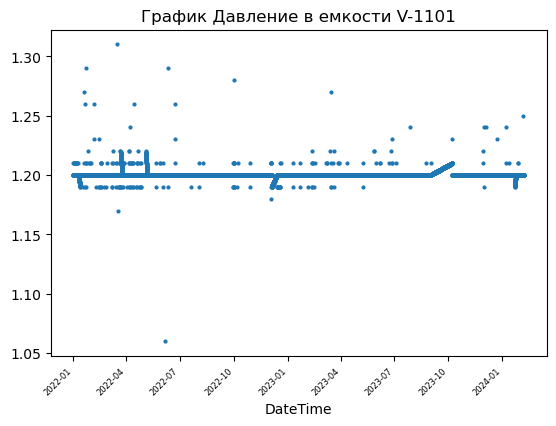

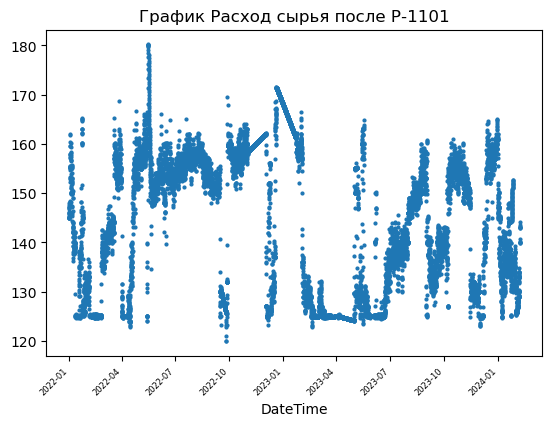

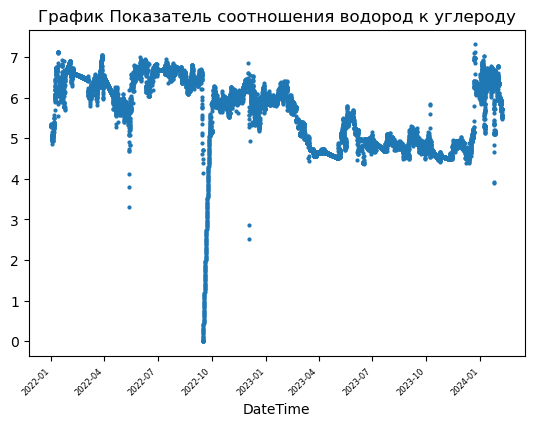

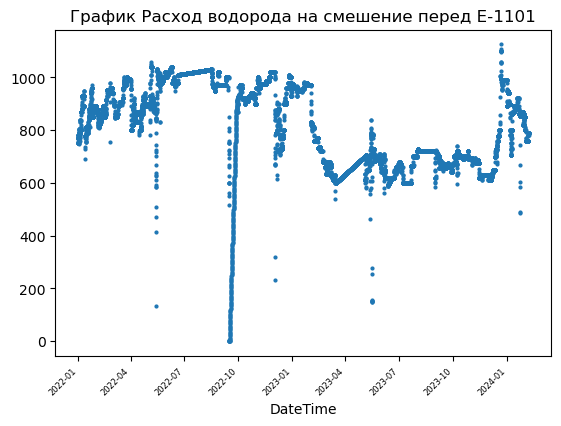

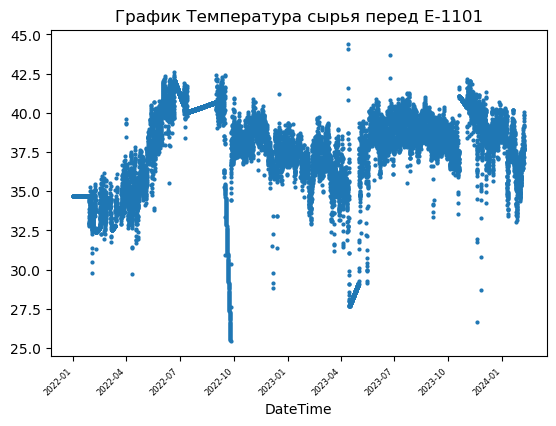

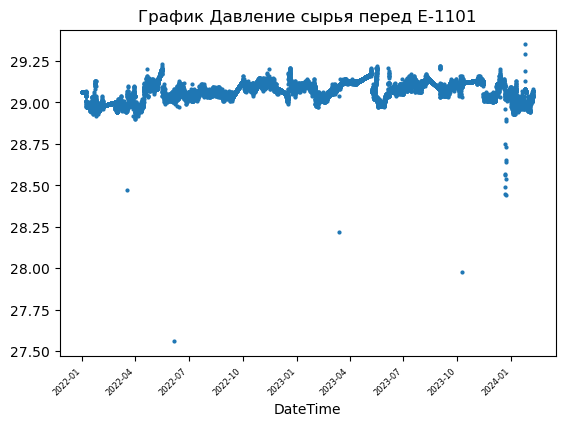

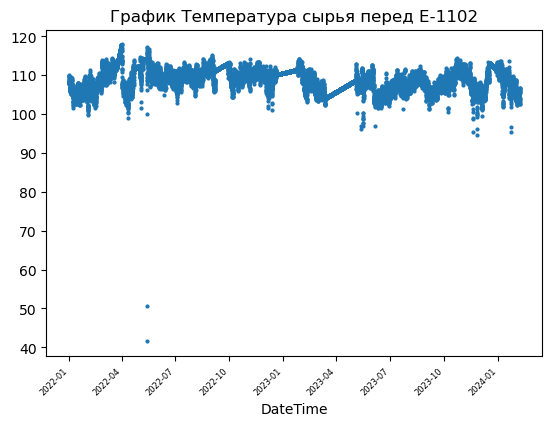

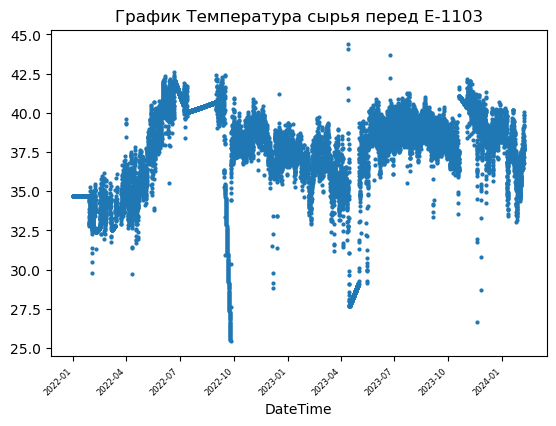

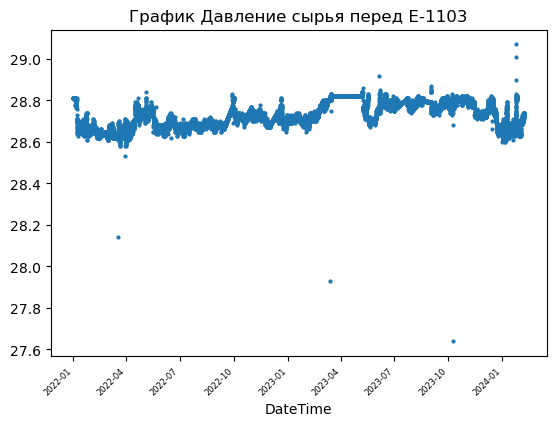

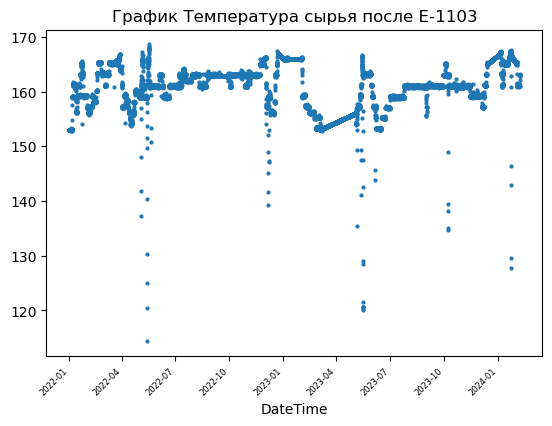

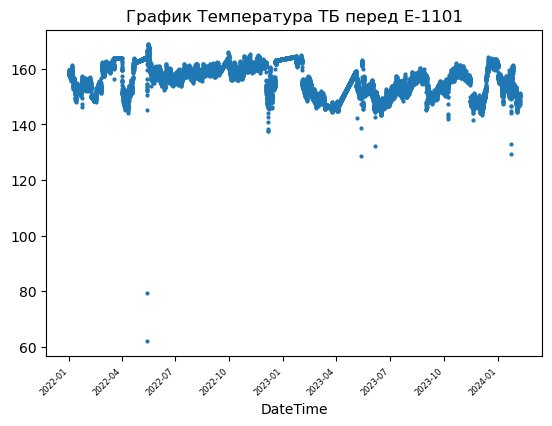

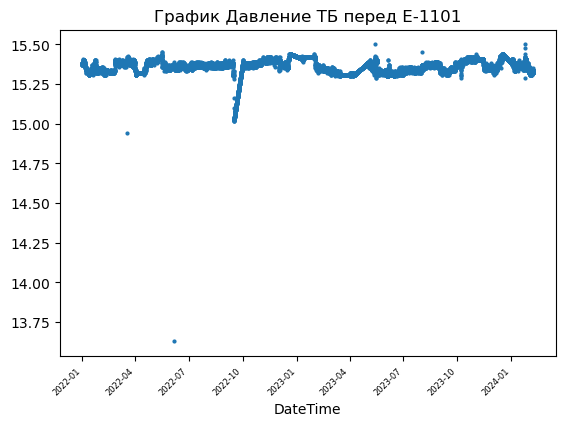

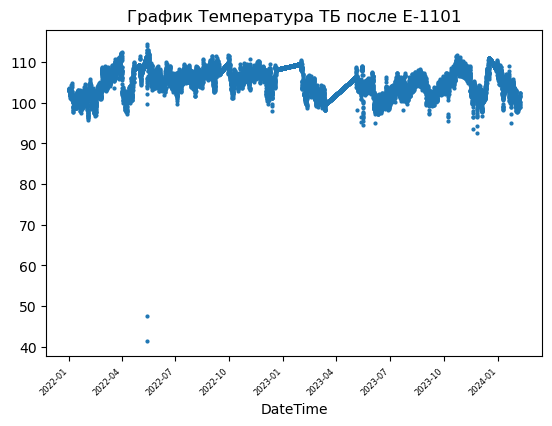

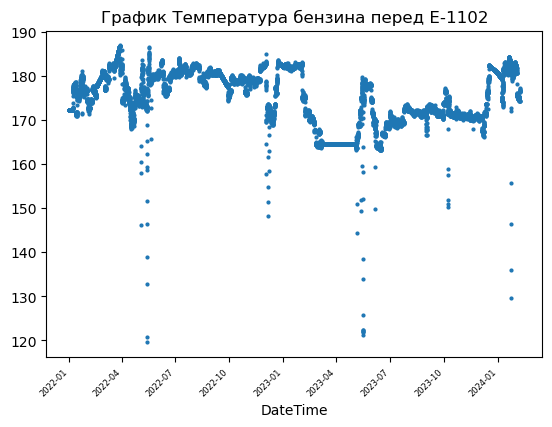

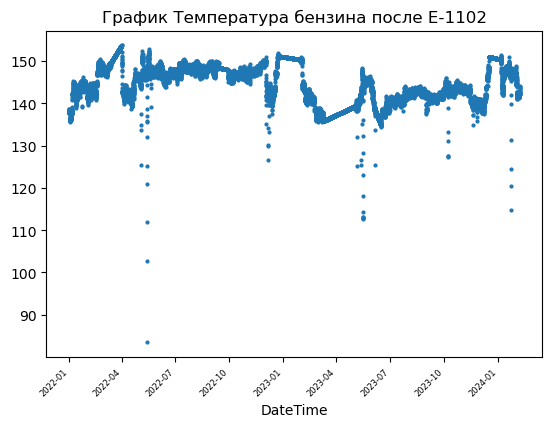

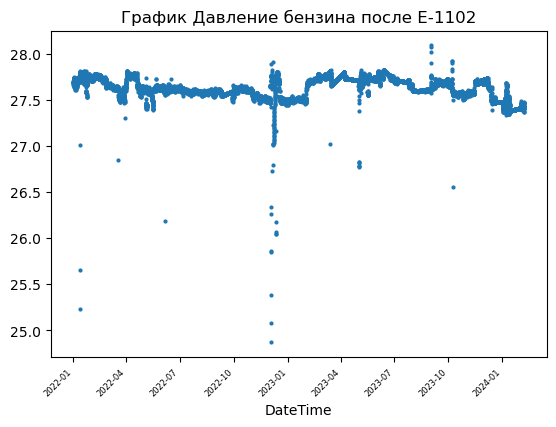

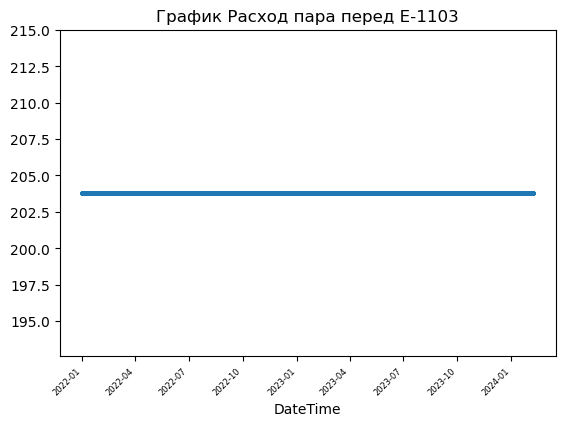

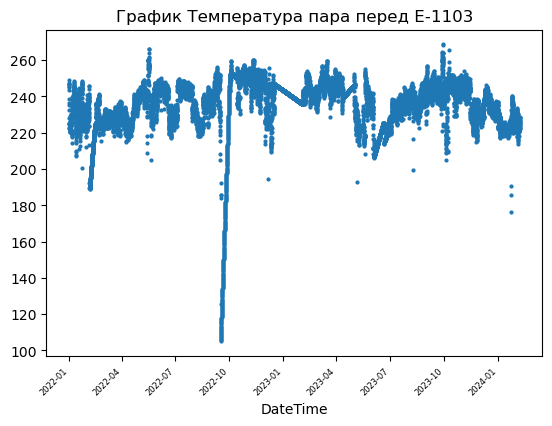

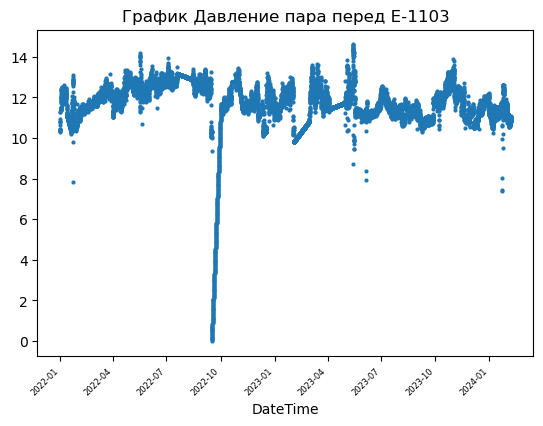

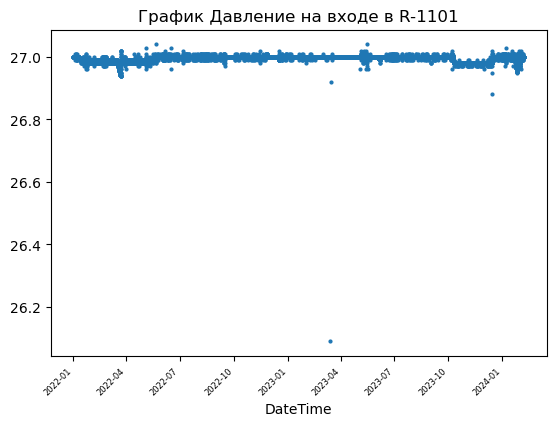

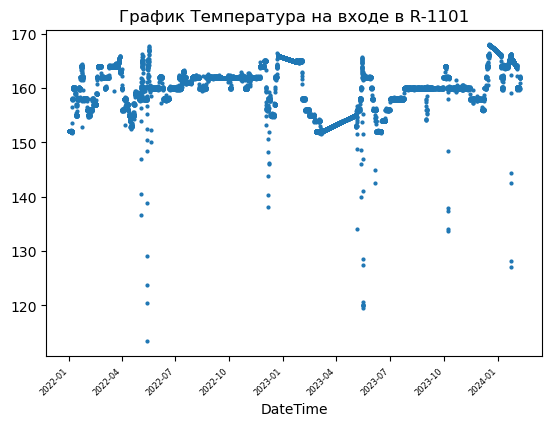

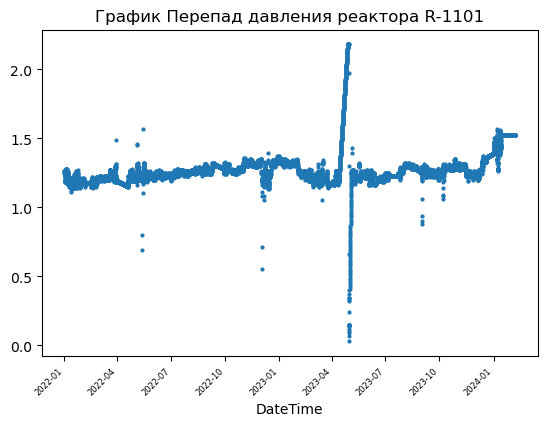

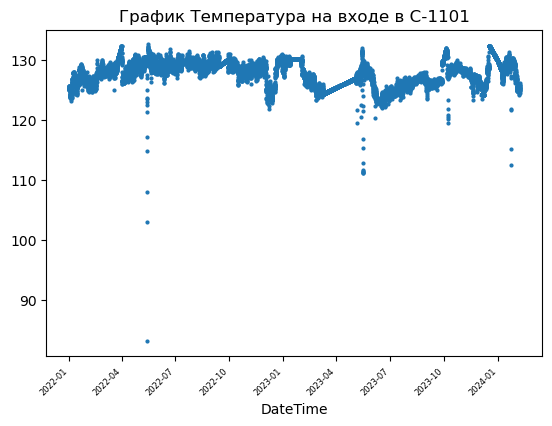

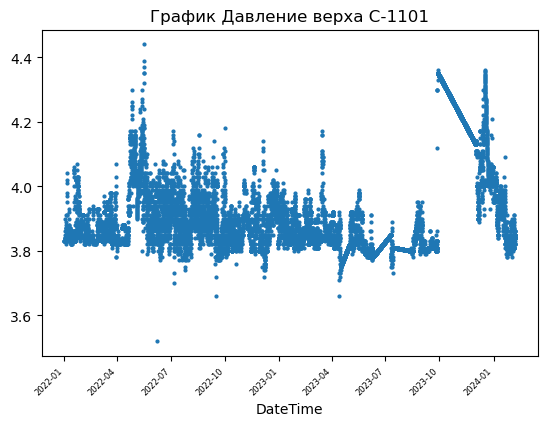

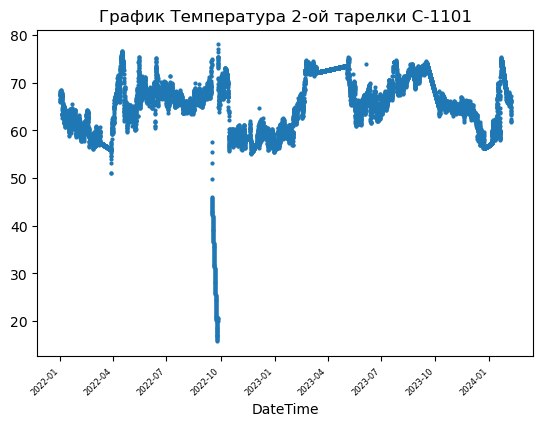

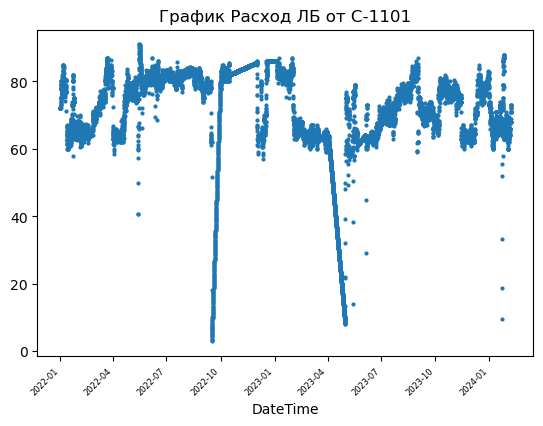

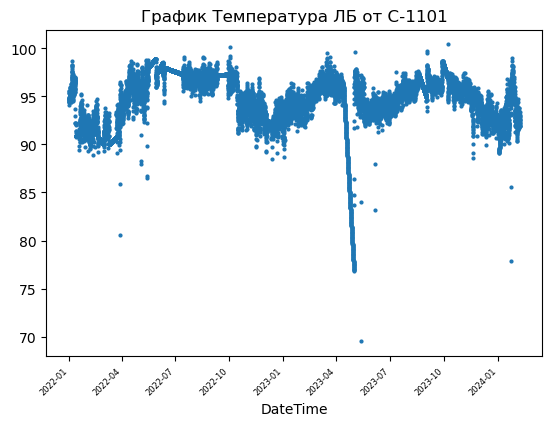

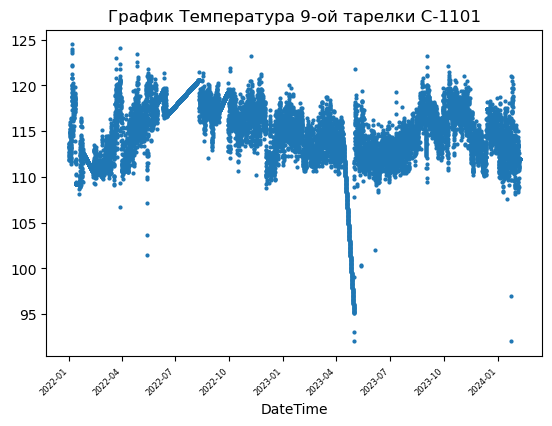

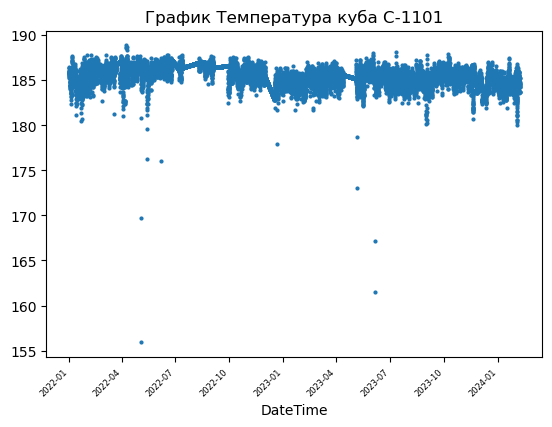

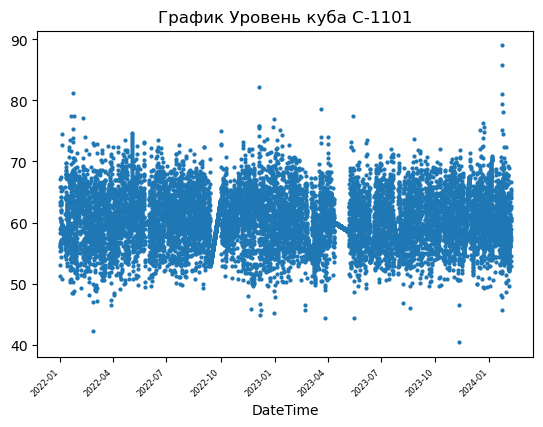

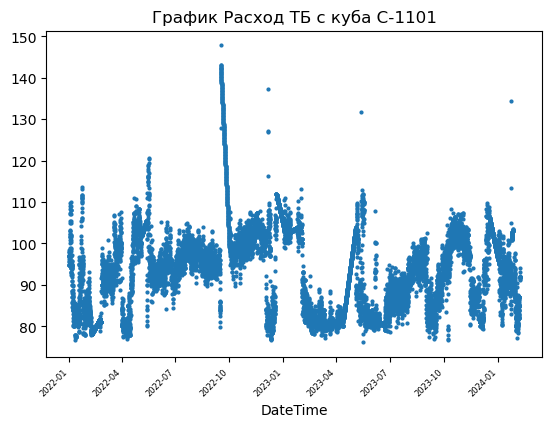

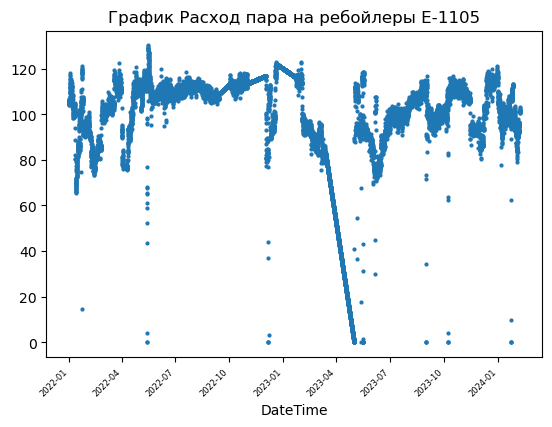

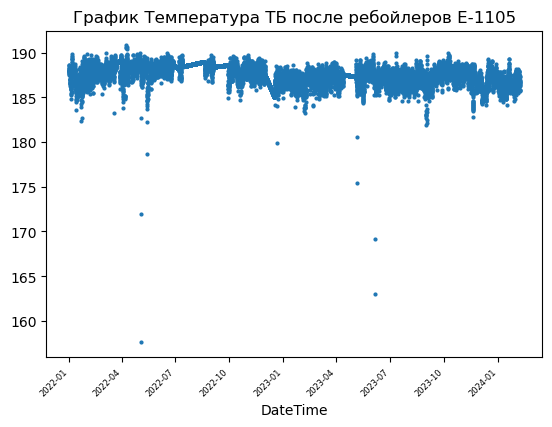

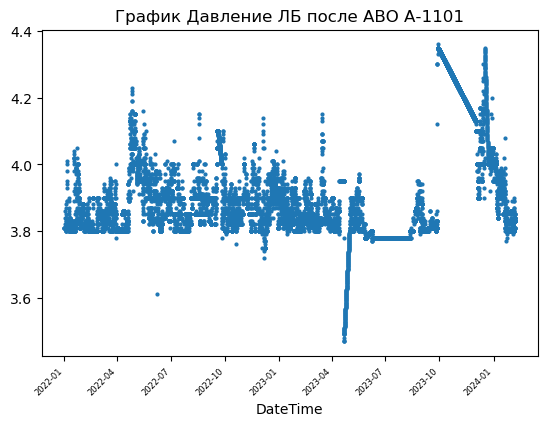

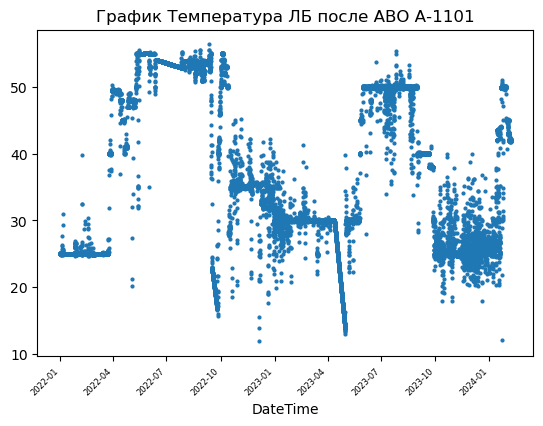

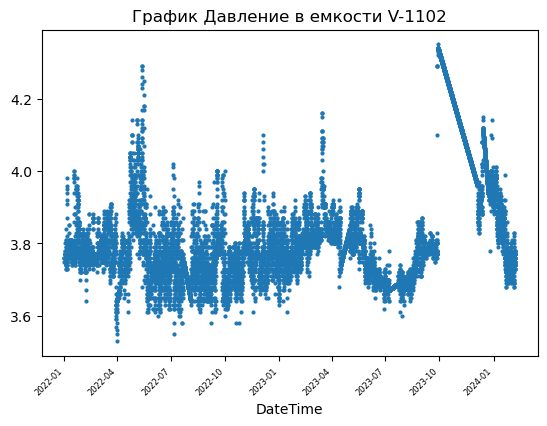

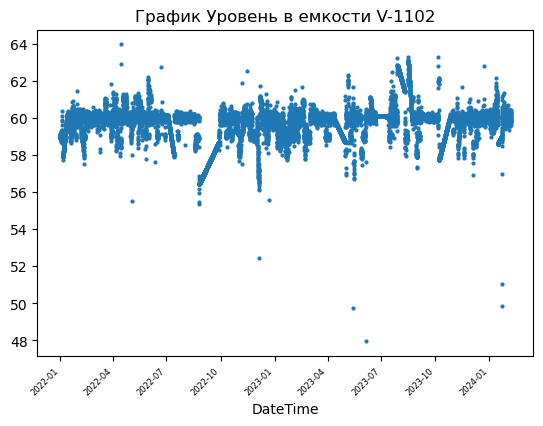

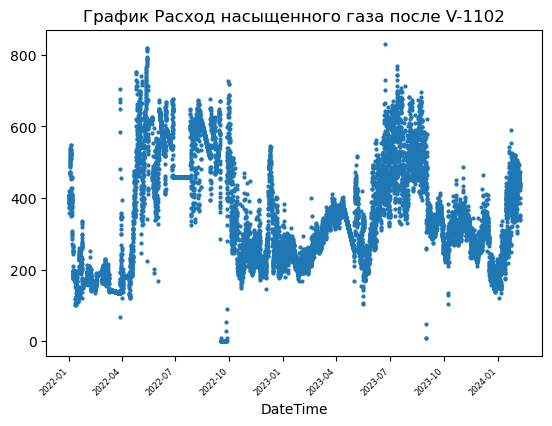

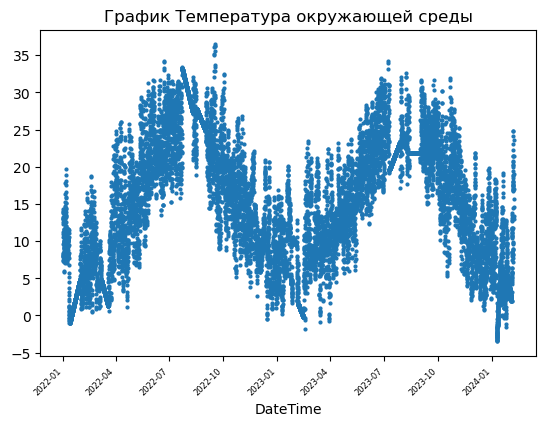

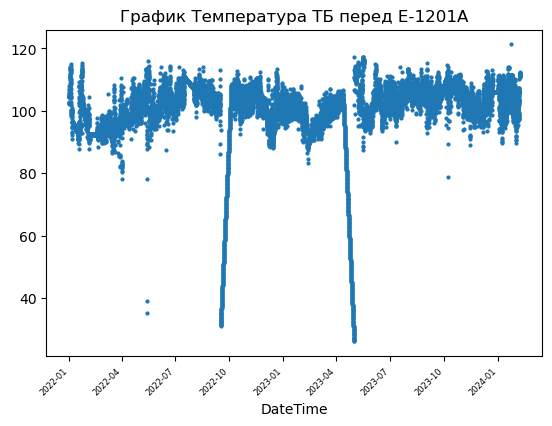

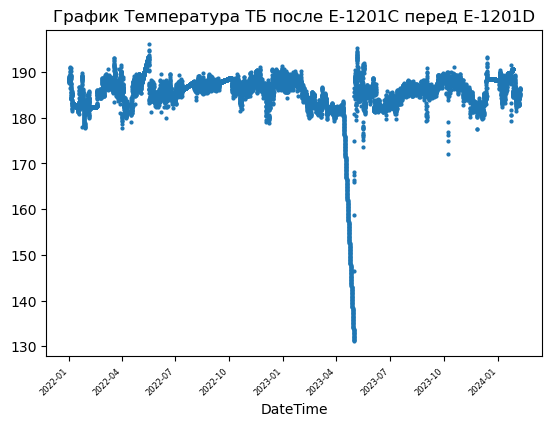

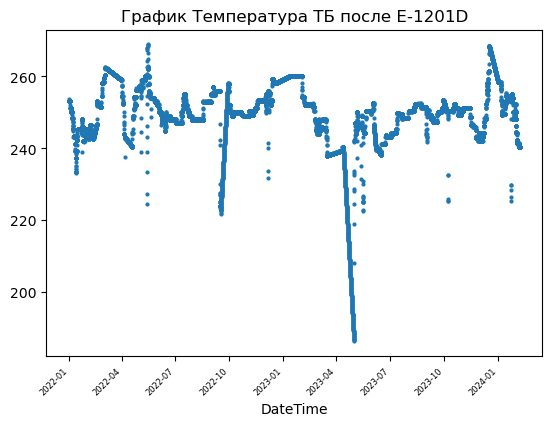

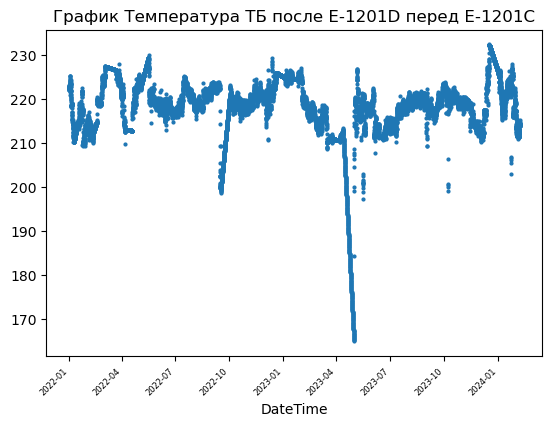

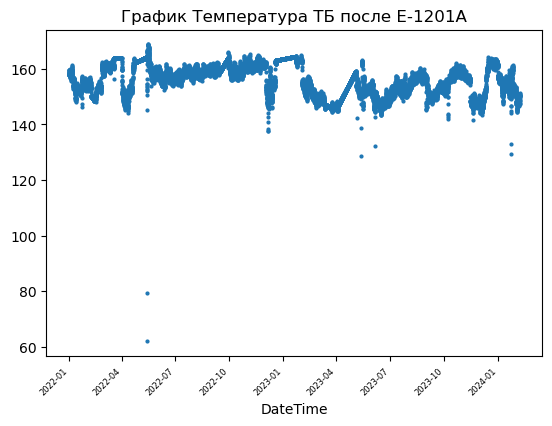

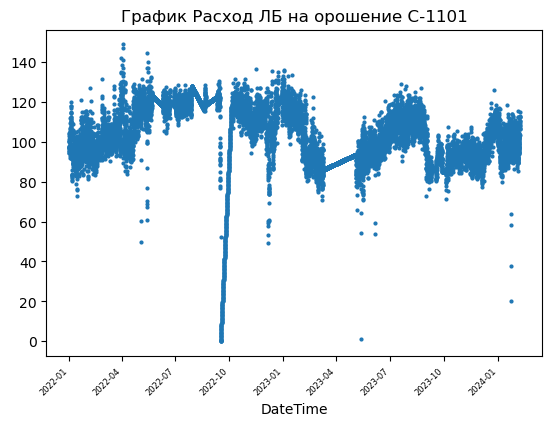

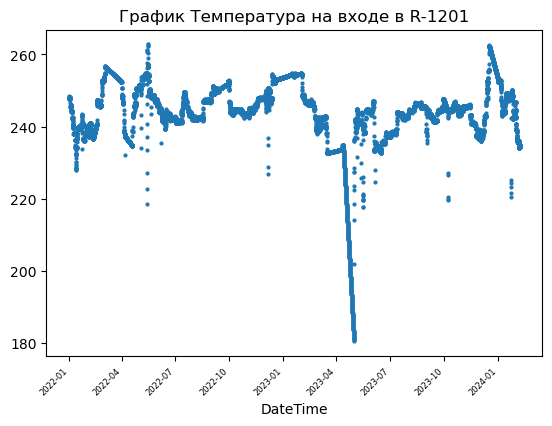

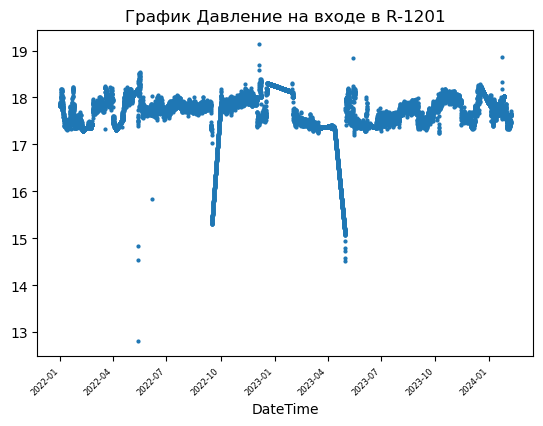

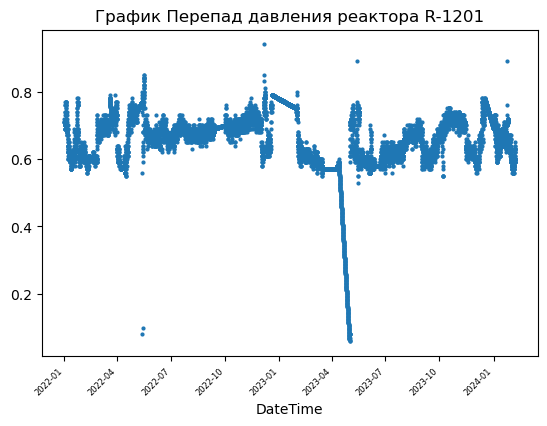

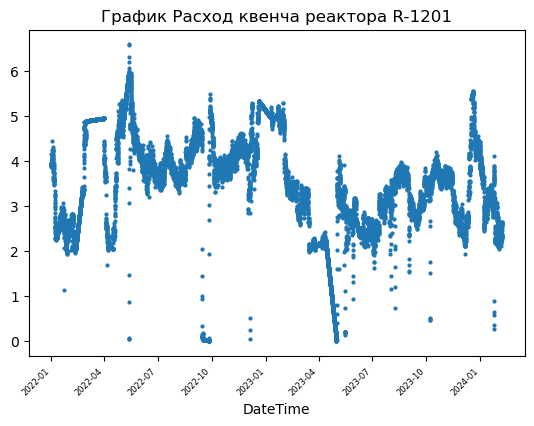

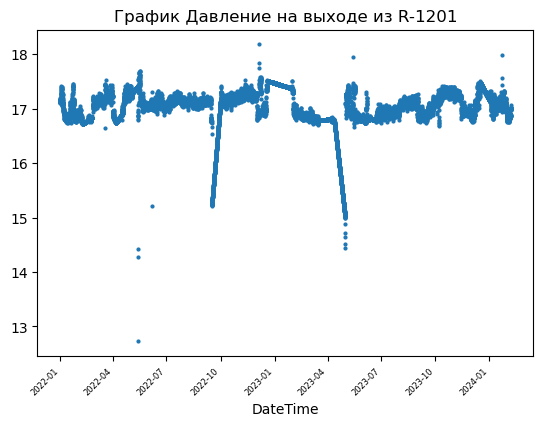

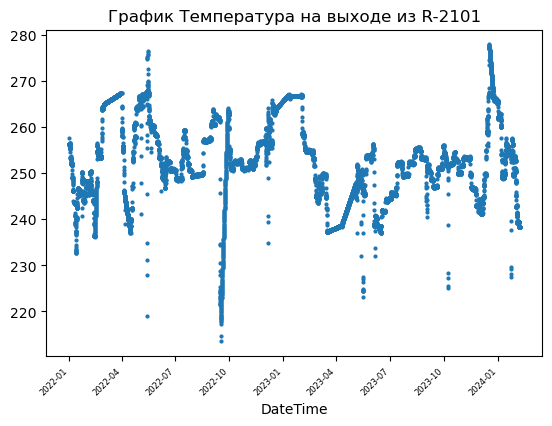

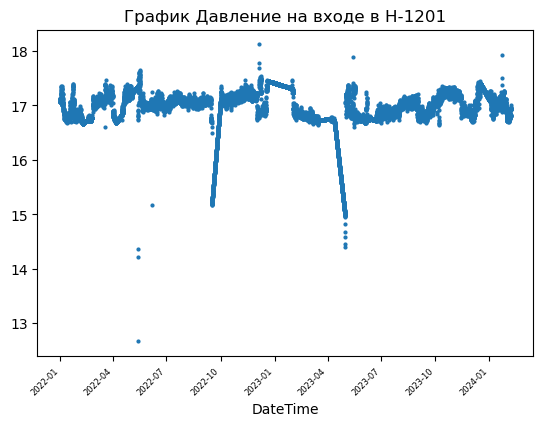

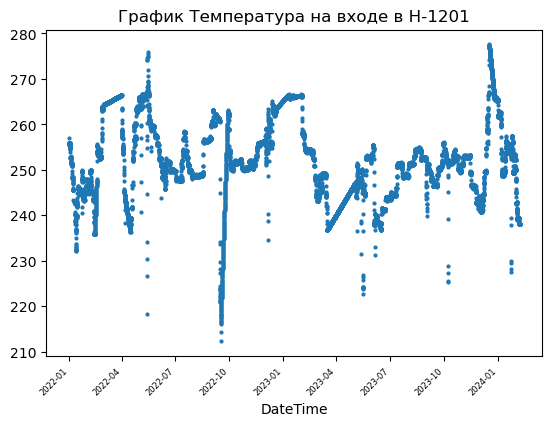

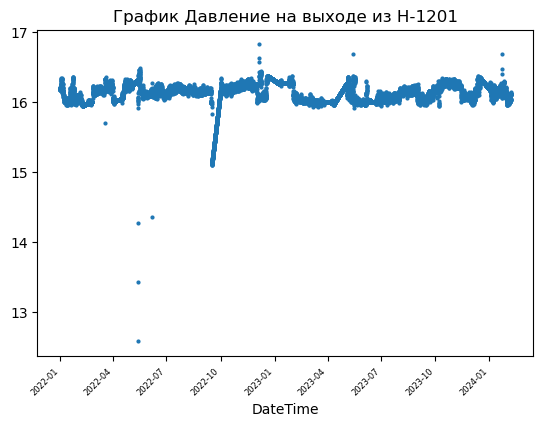

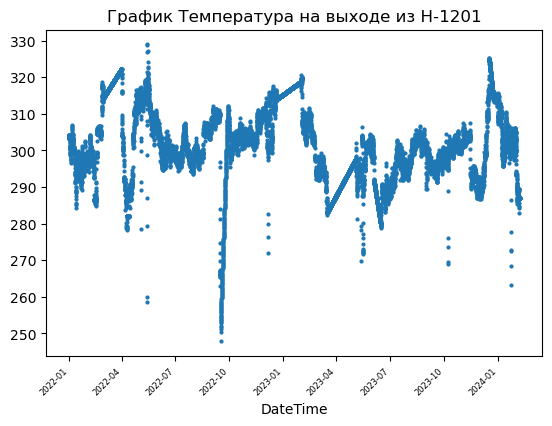

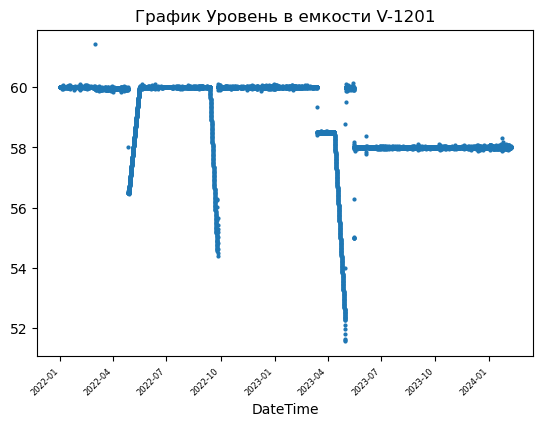

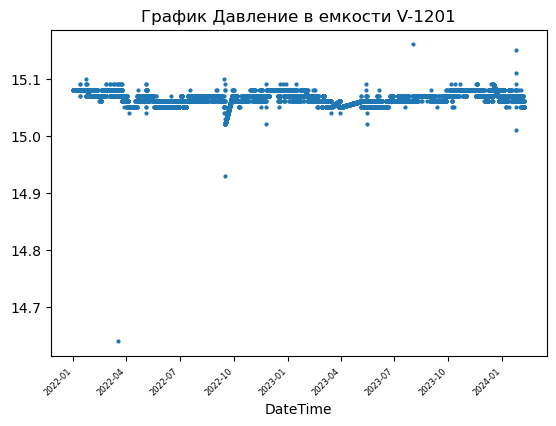

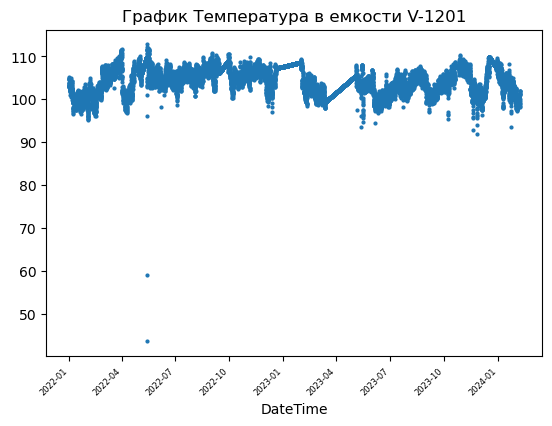

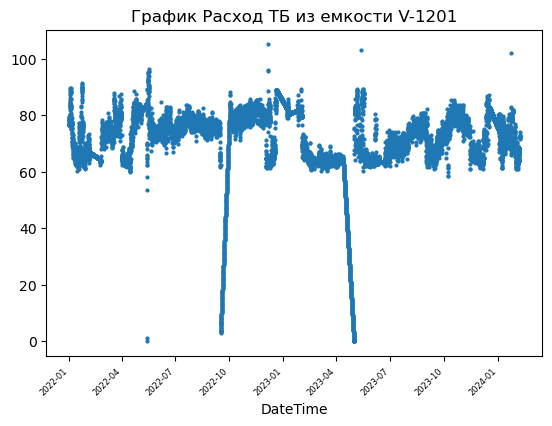

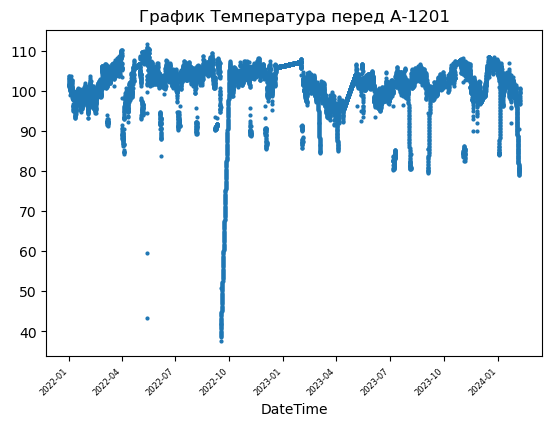

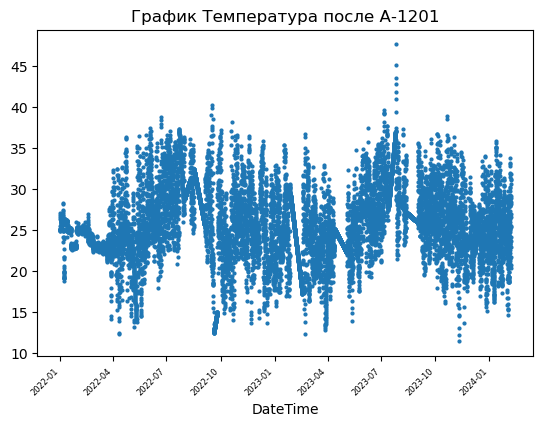

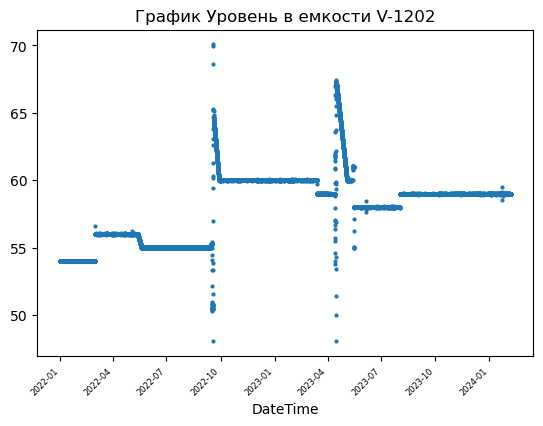

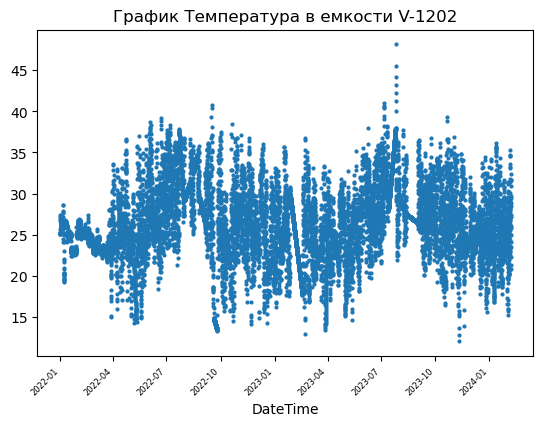

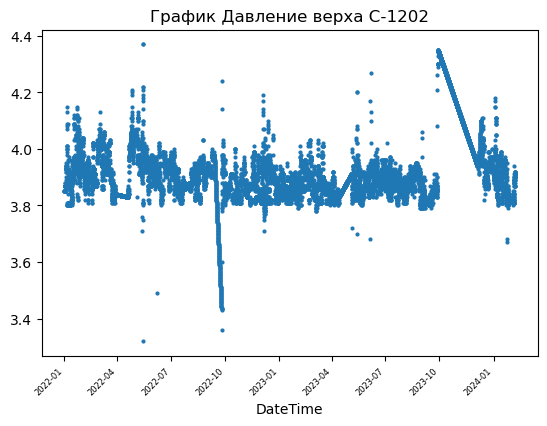

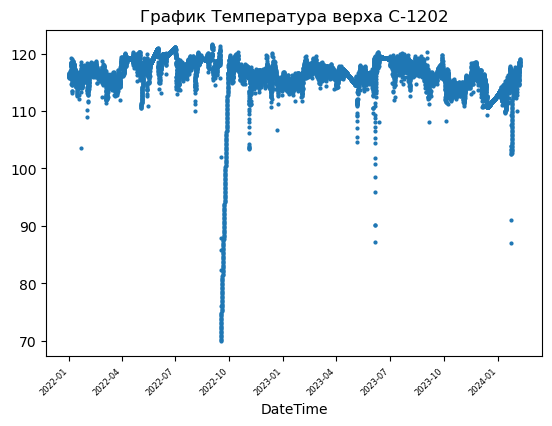

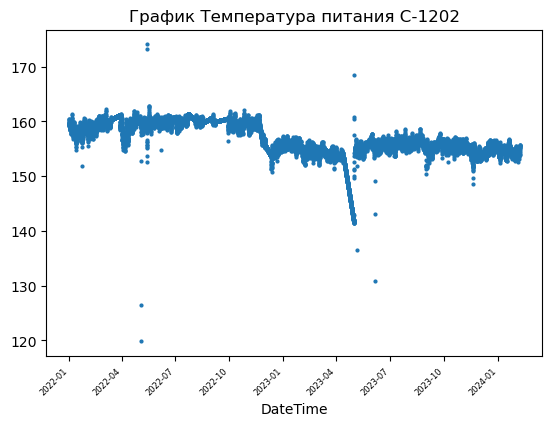

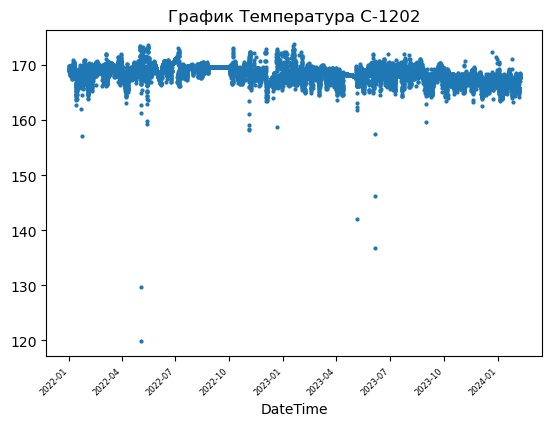

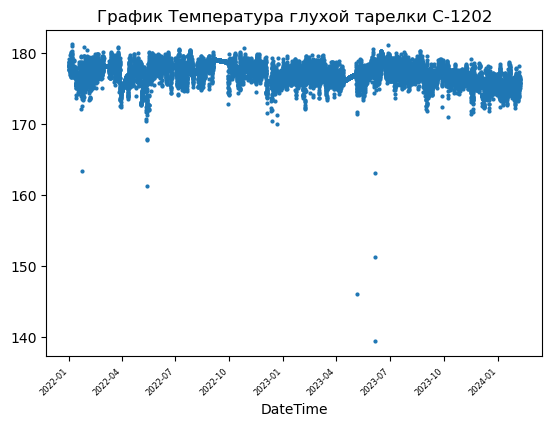

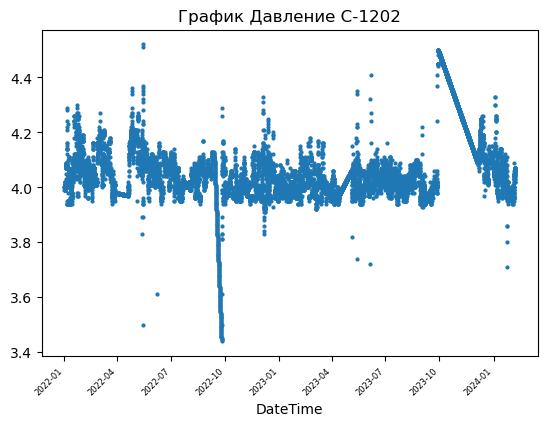

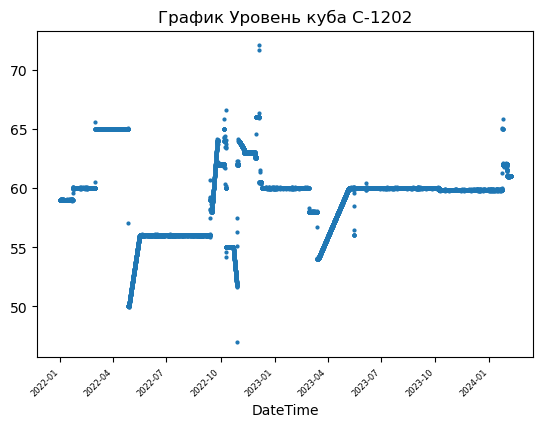

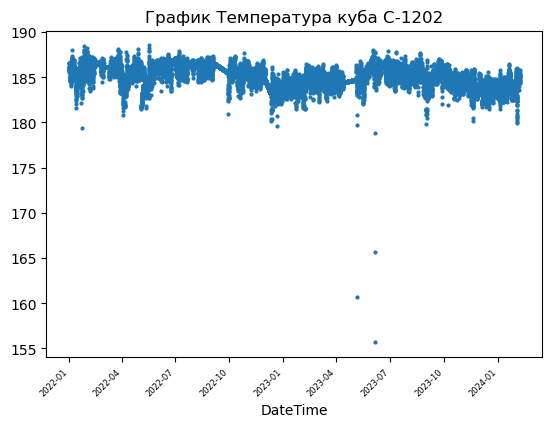

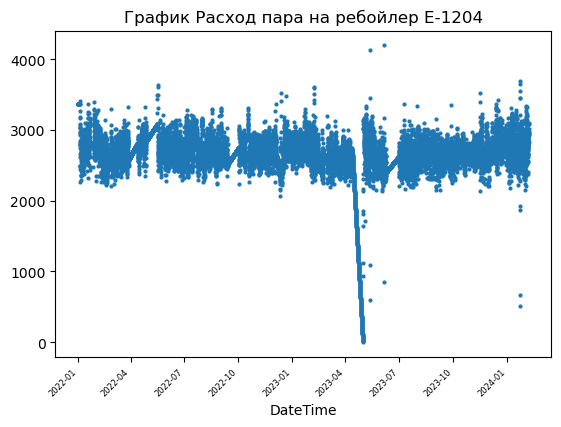

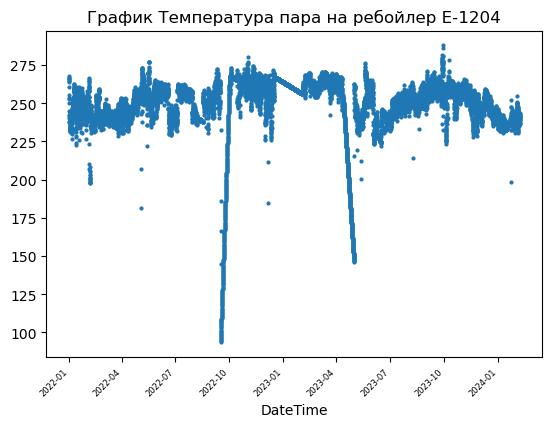

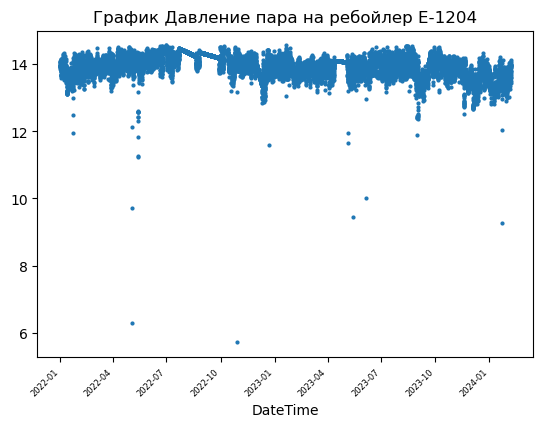

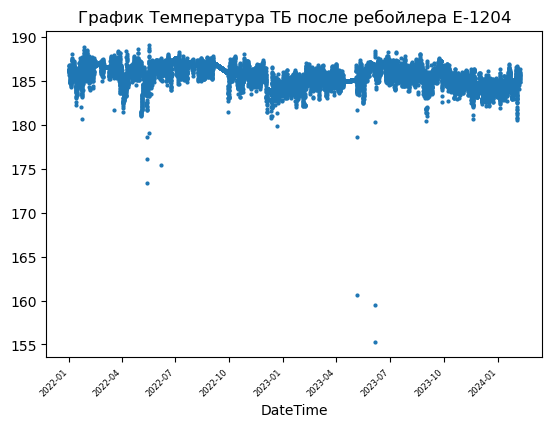

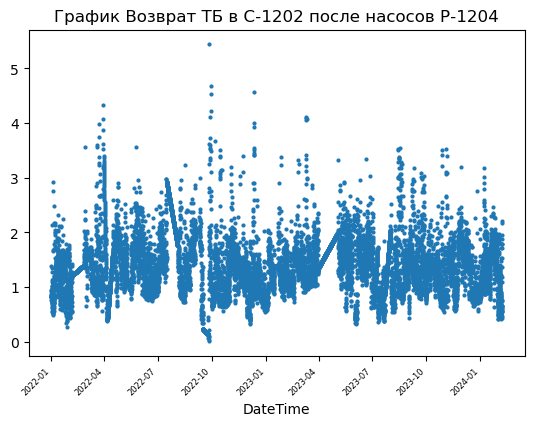

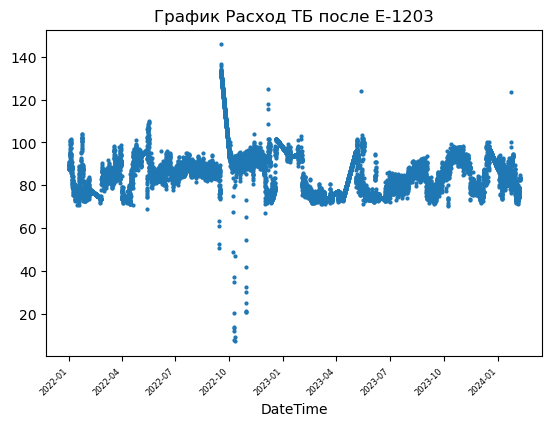

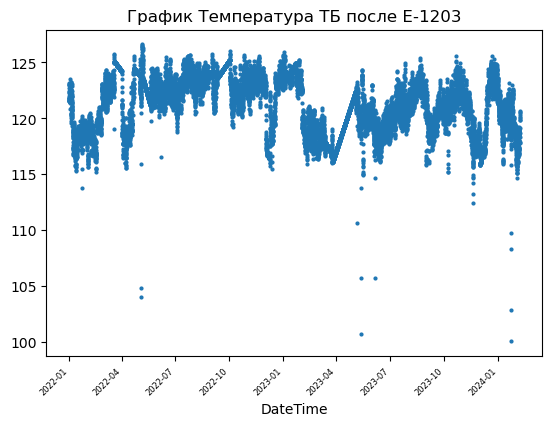

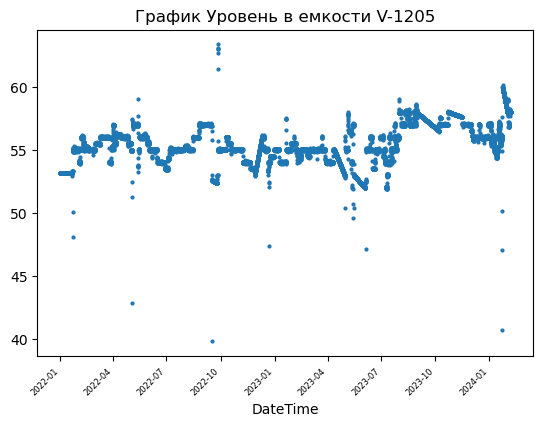

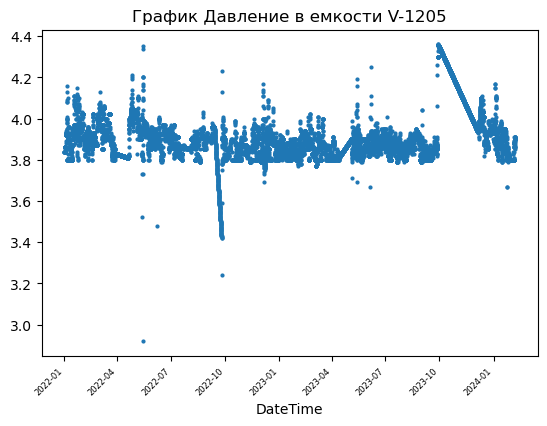

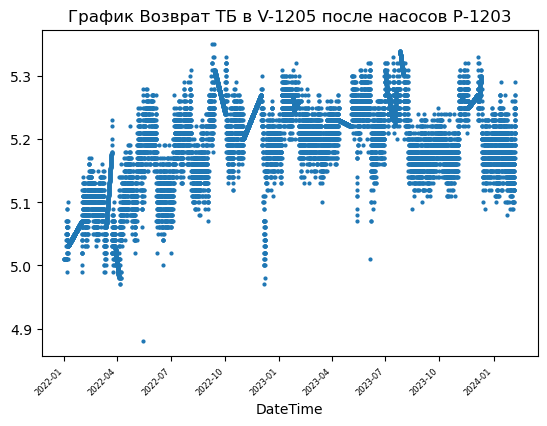

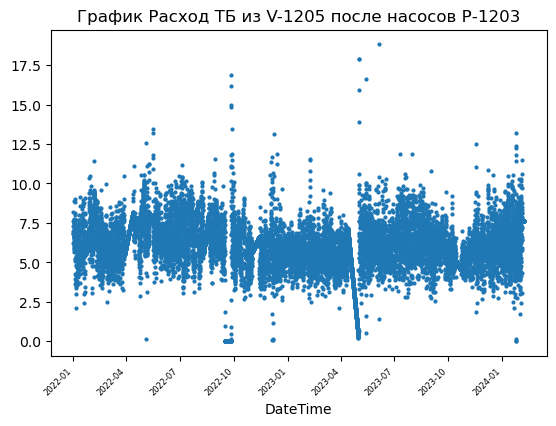

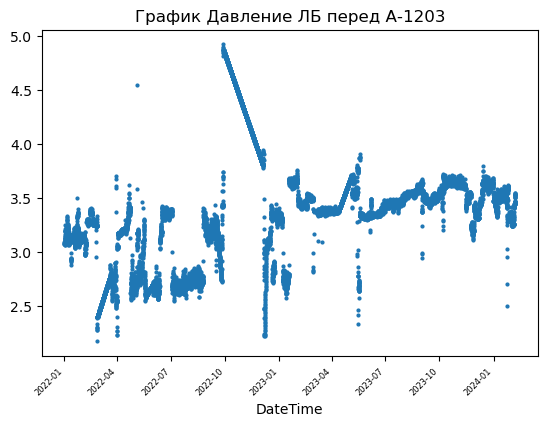

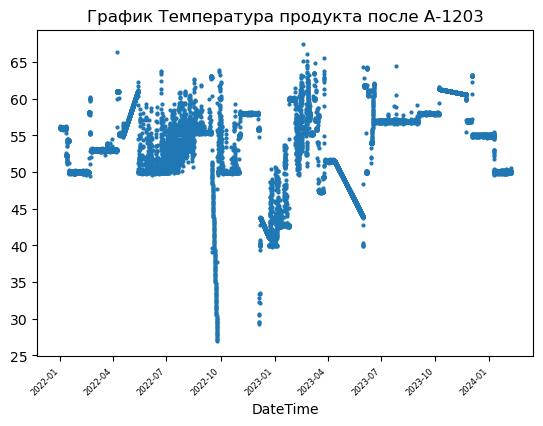

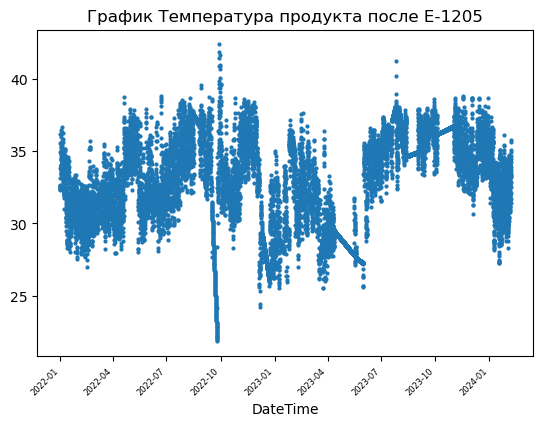

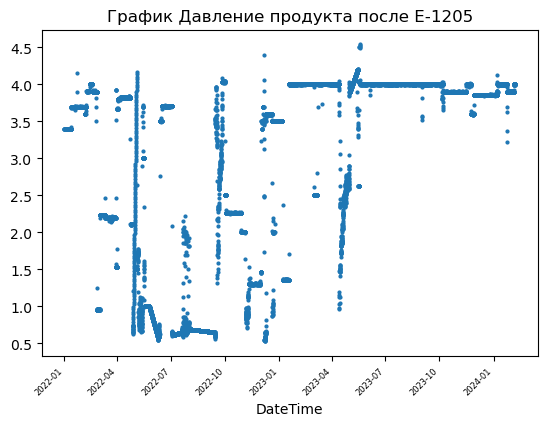

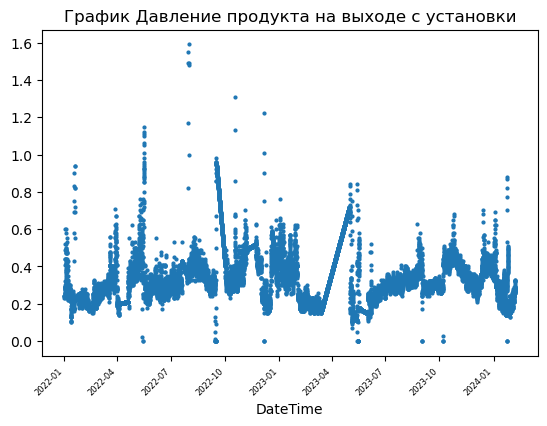

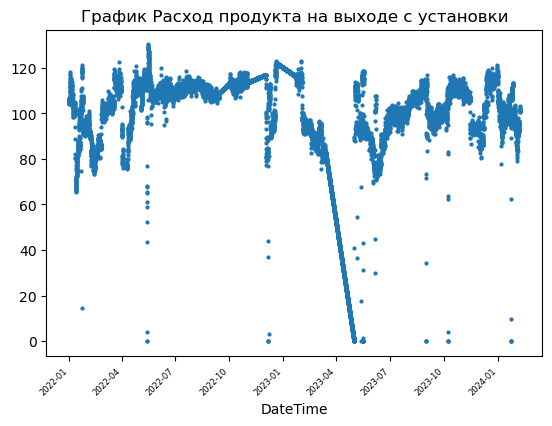

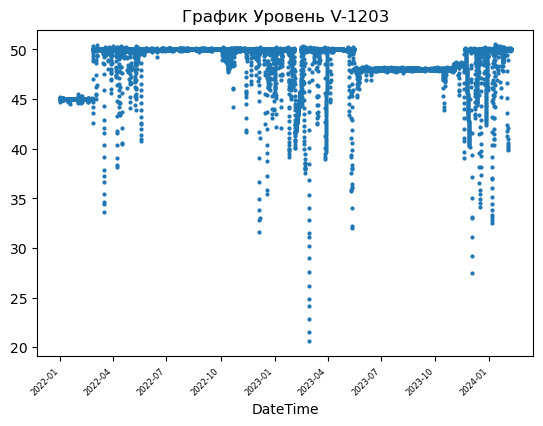

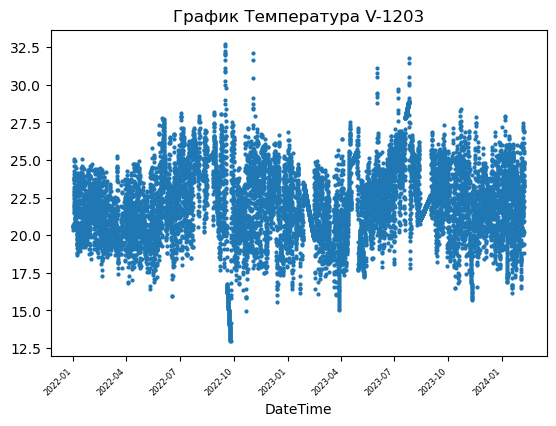

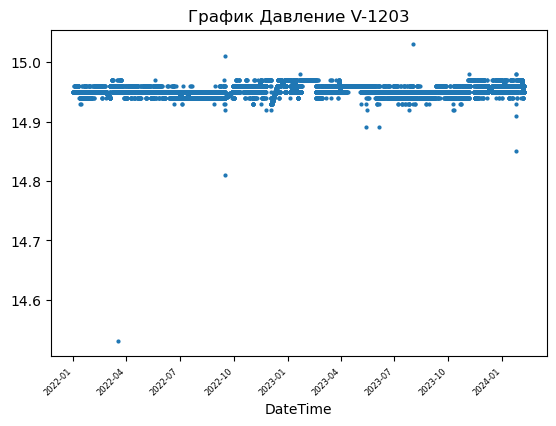

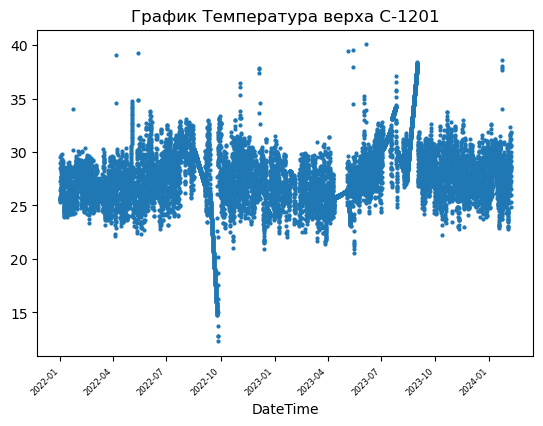

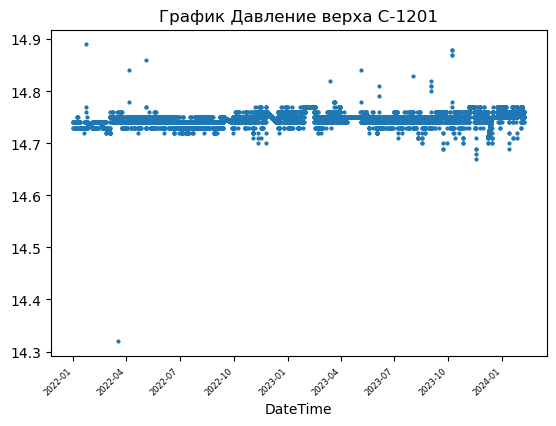

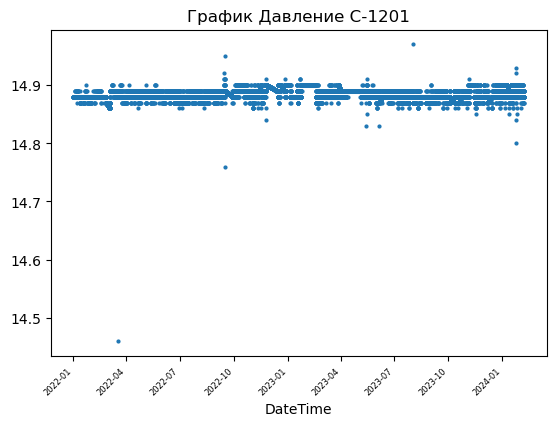

In [17]:
parameter_vis(filtered_df)

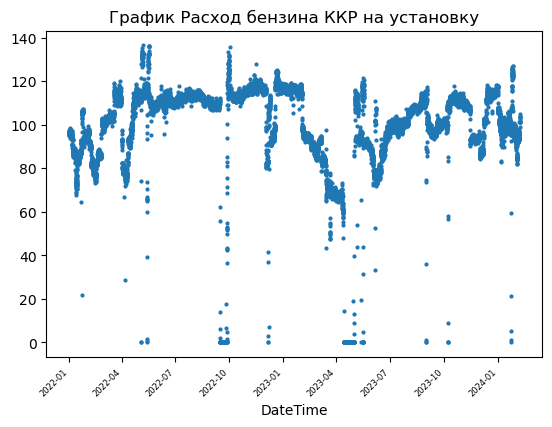

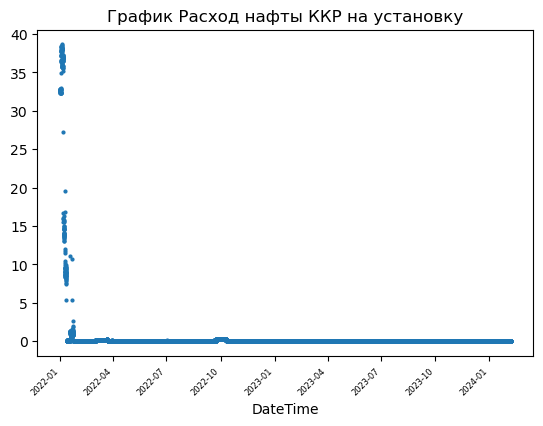

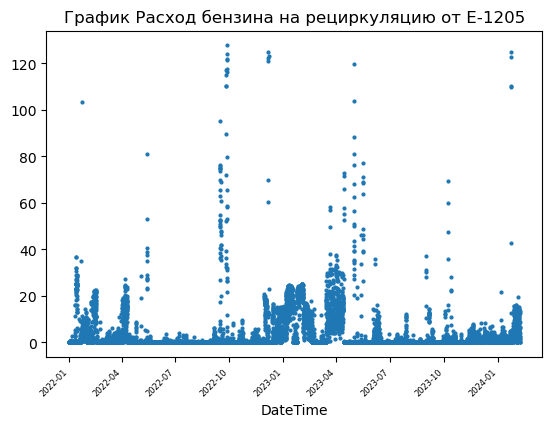

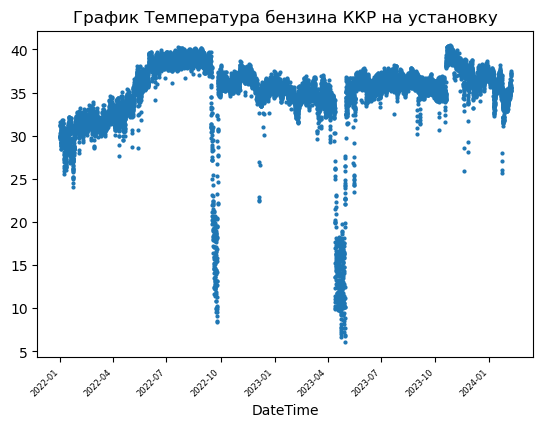

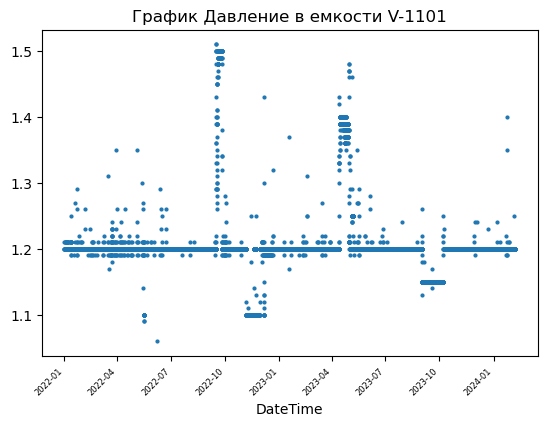

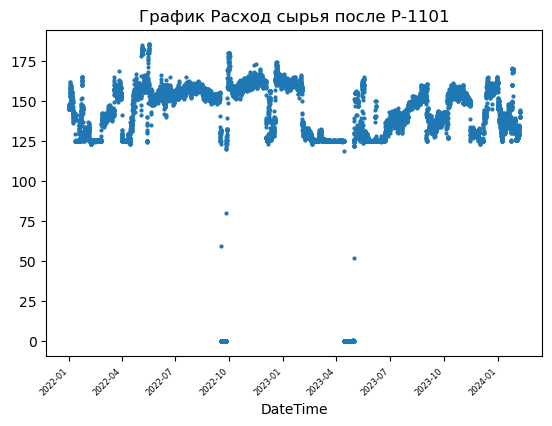

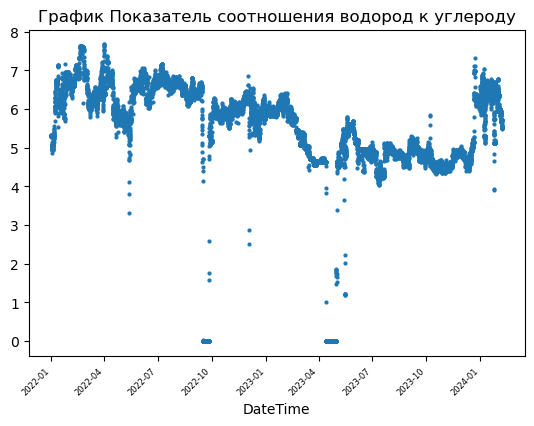

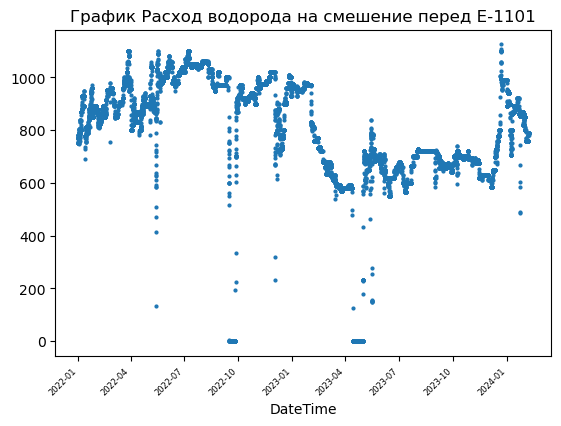

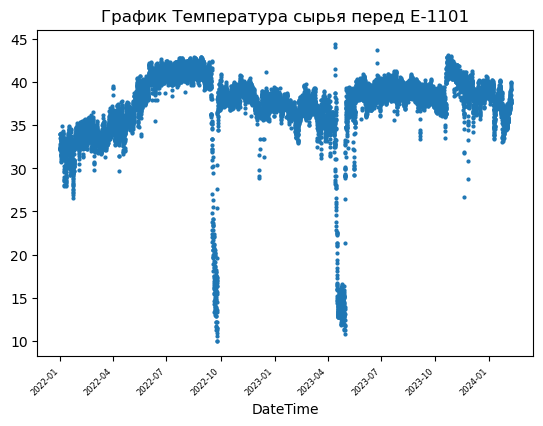

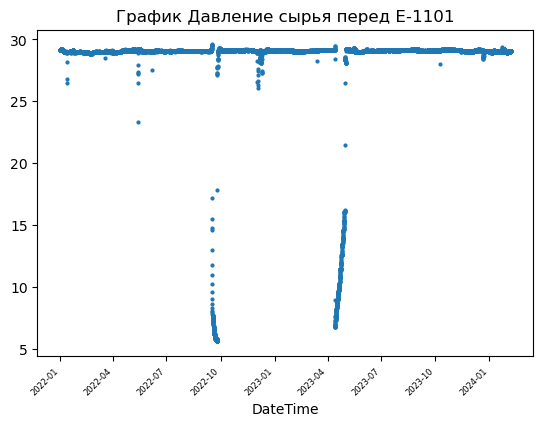

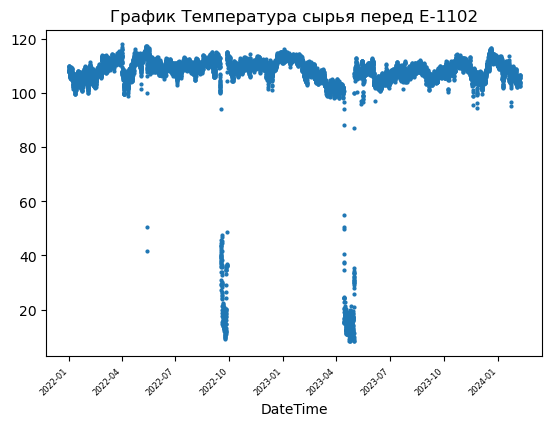

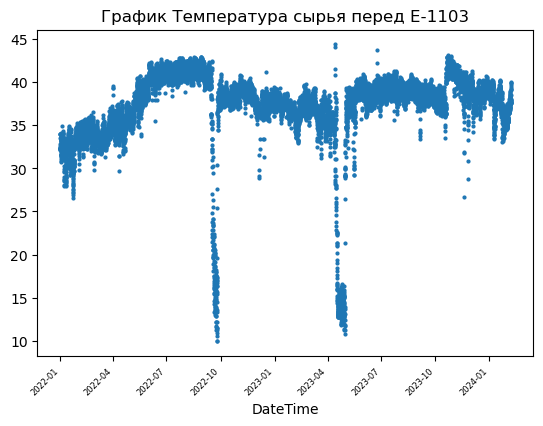

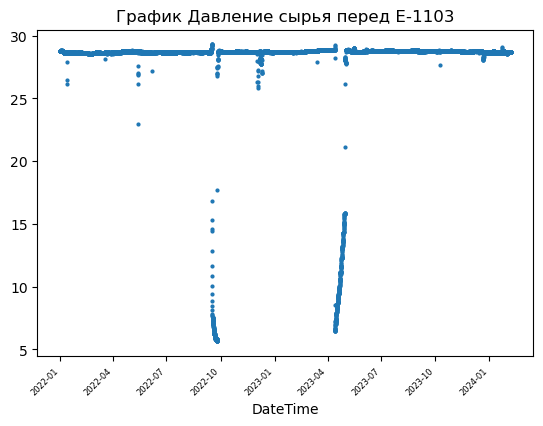

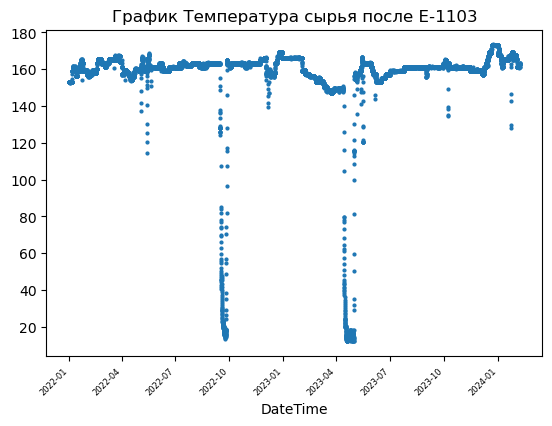

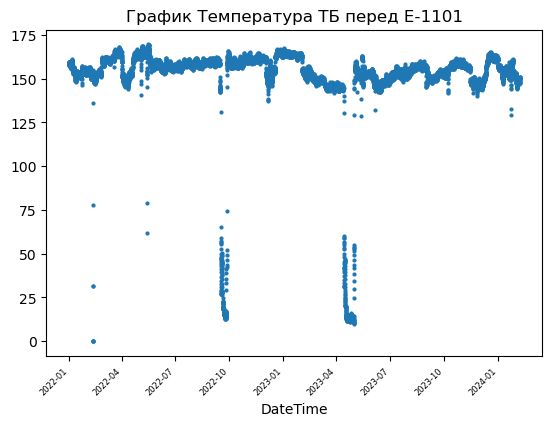

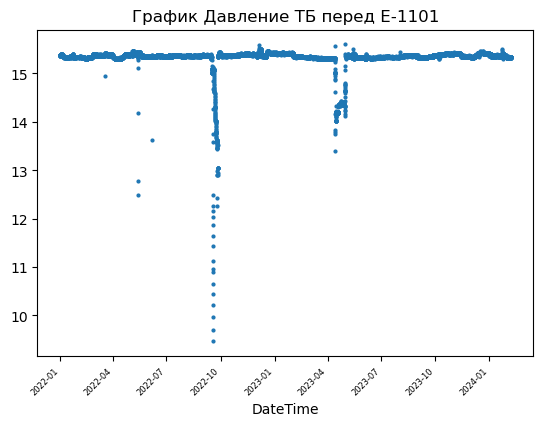

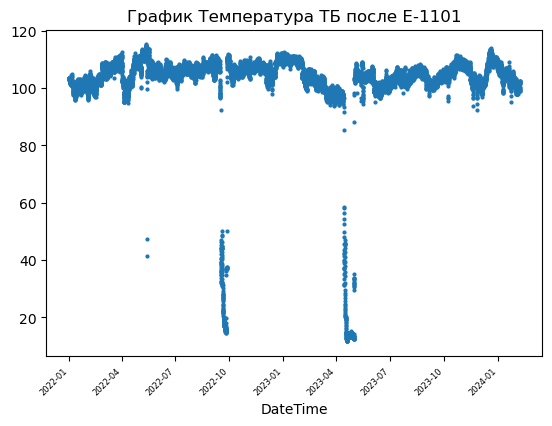

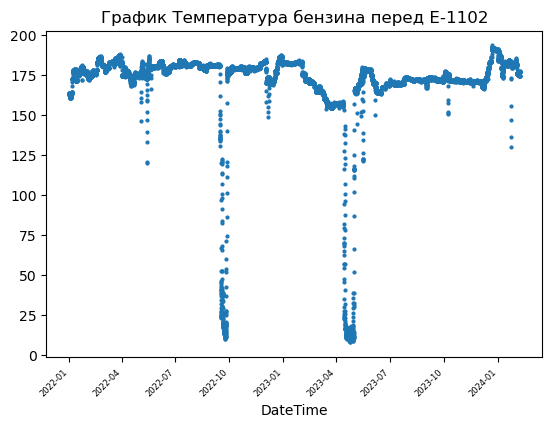

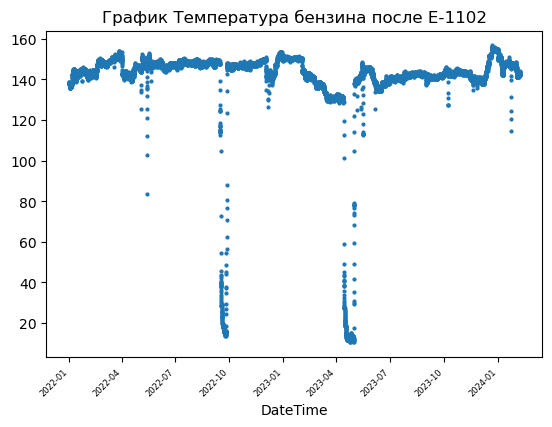

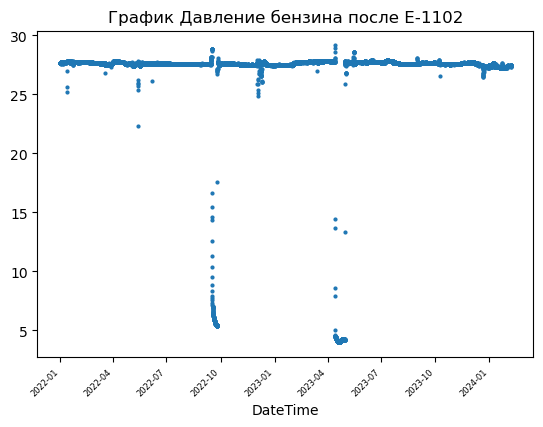

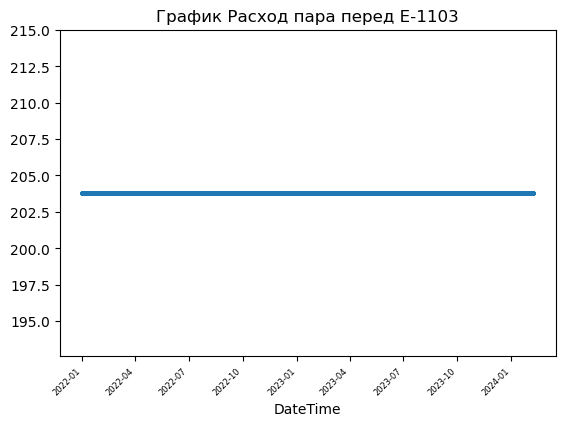

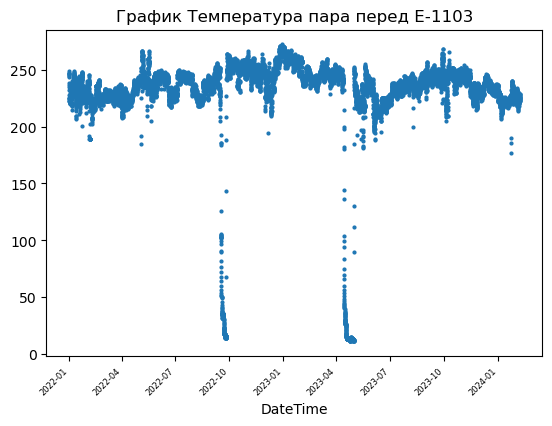

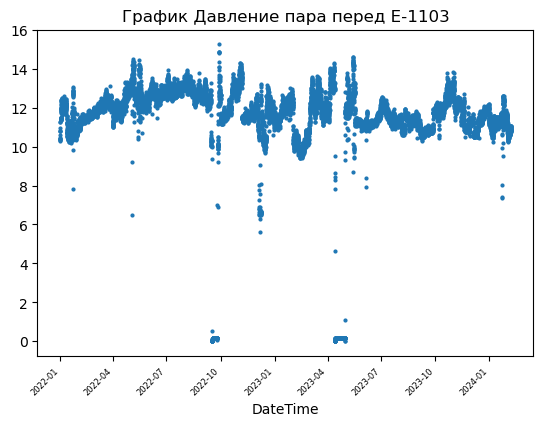

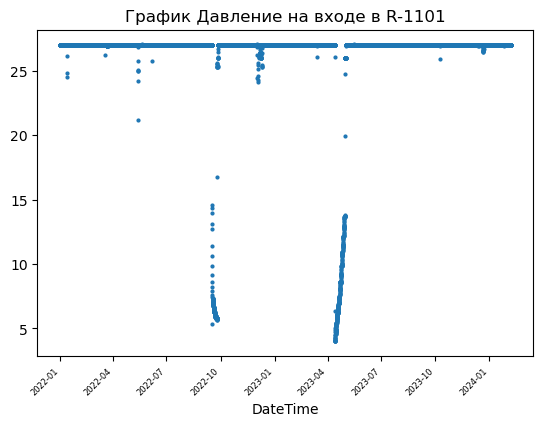

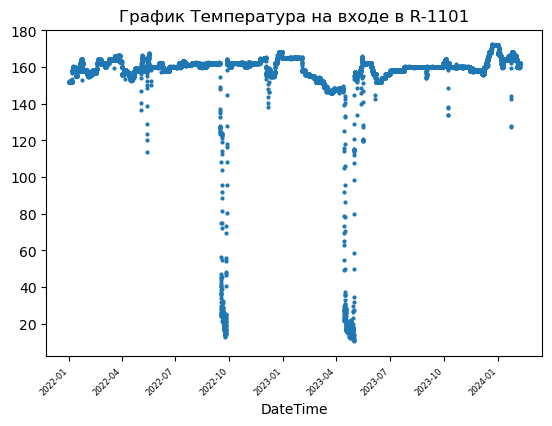

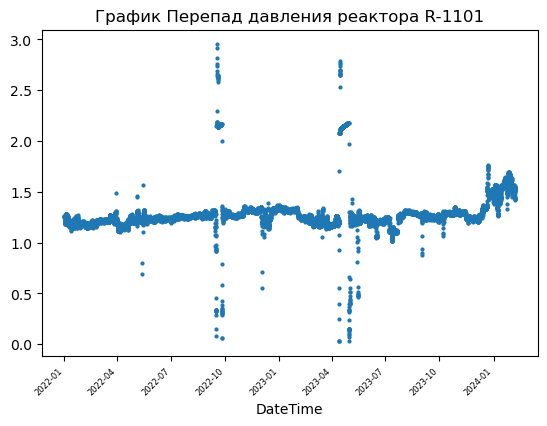

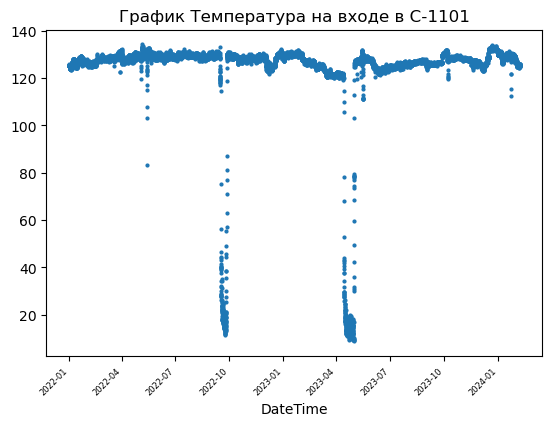

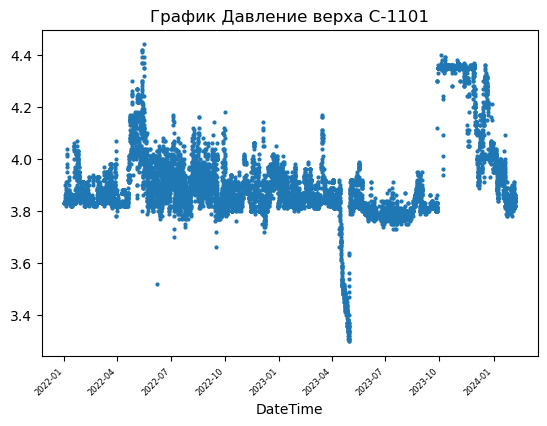

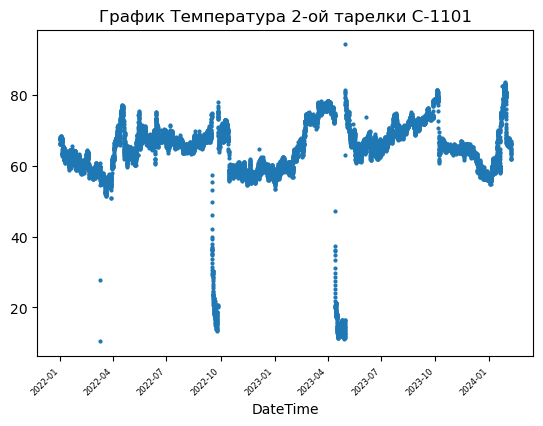

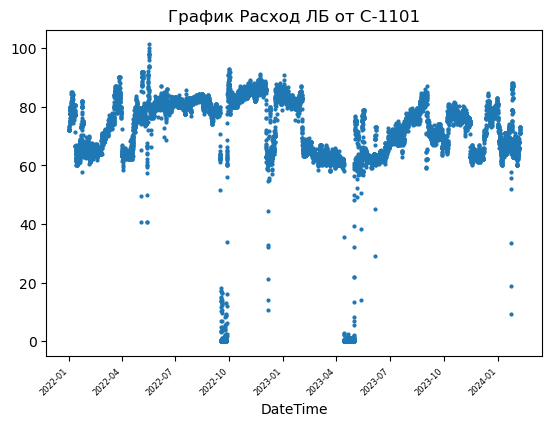

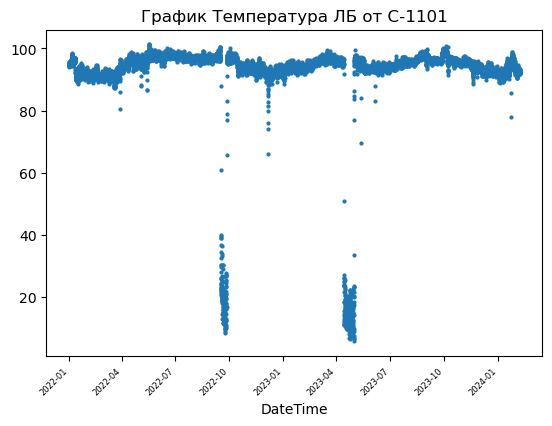

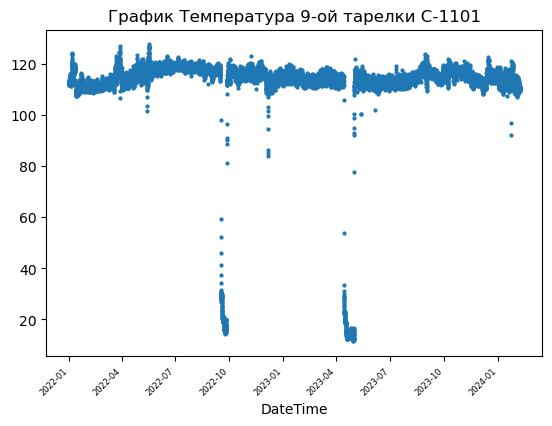

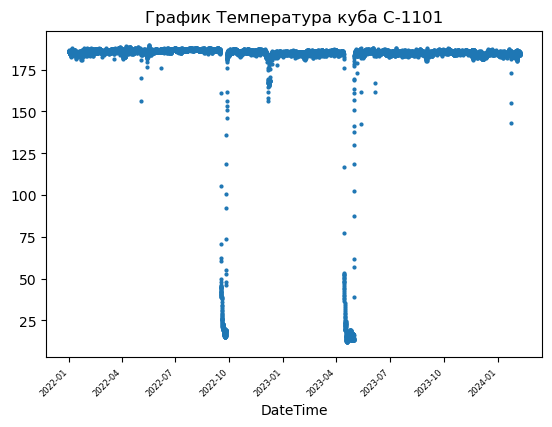

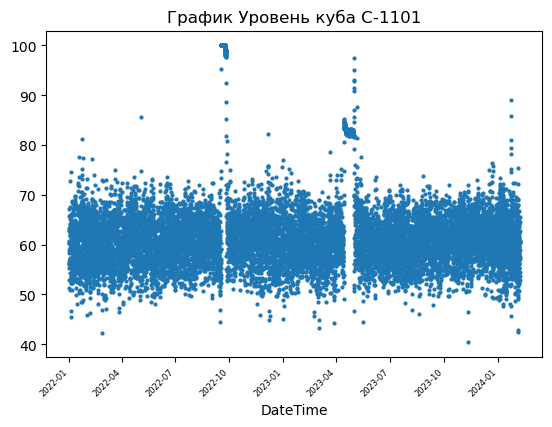

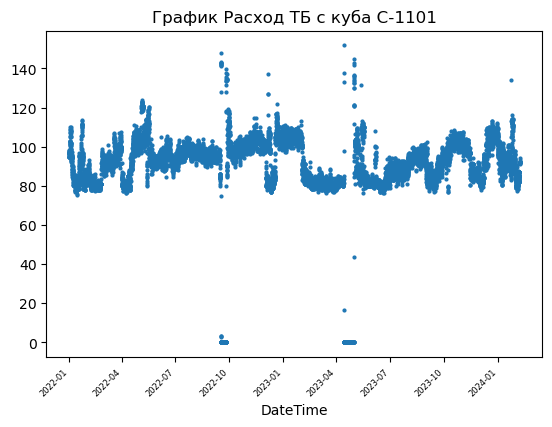

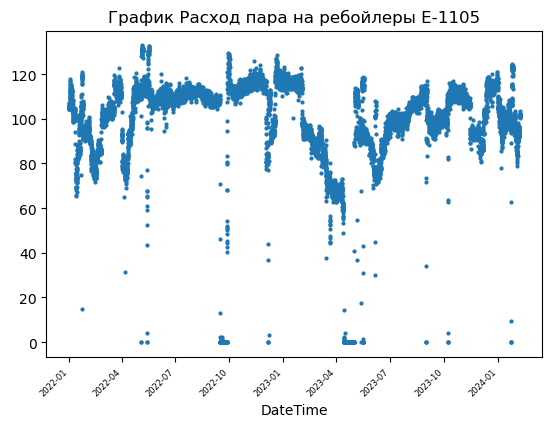

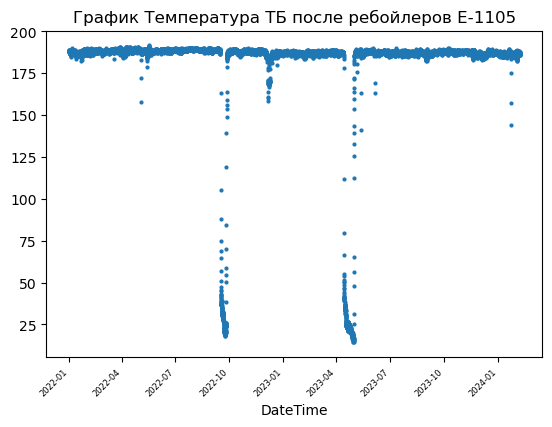

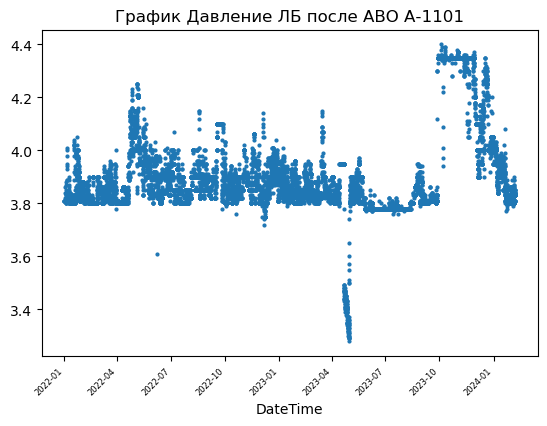

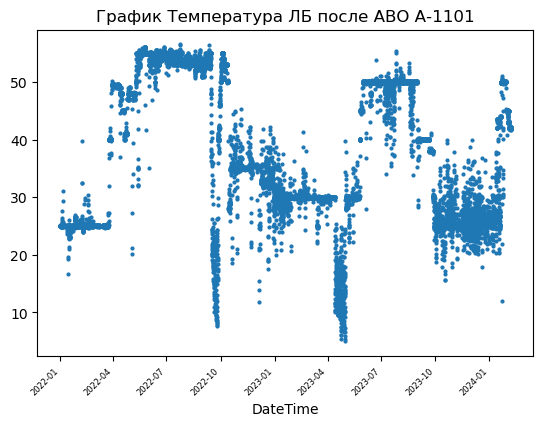

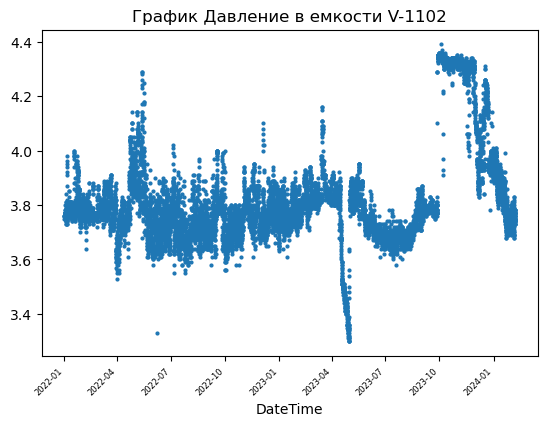

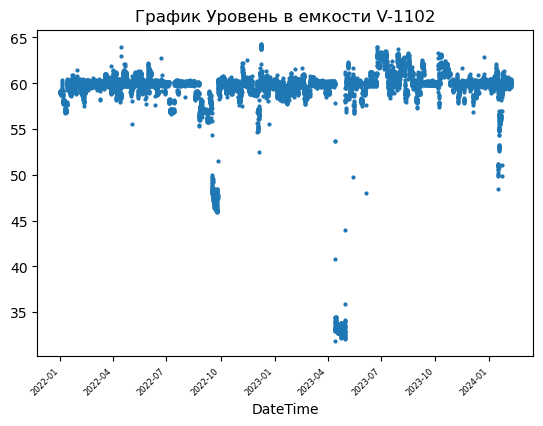

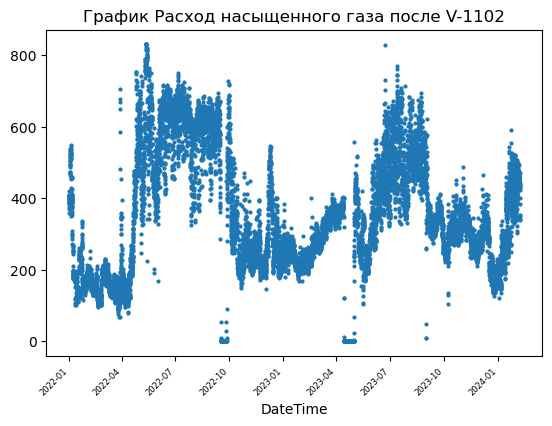

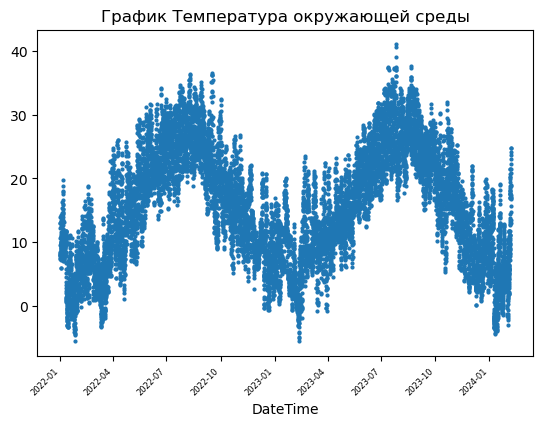

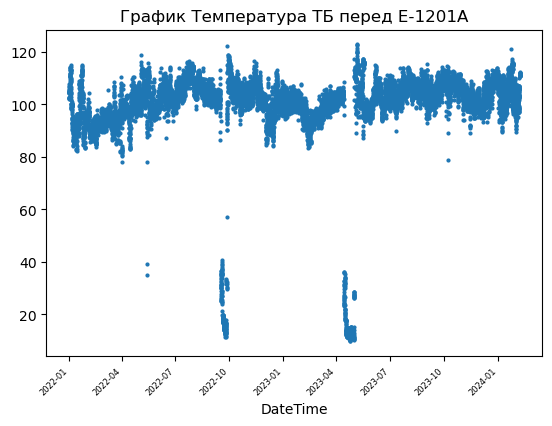

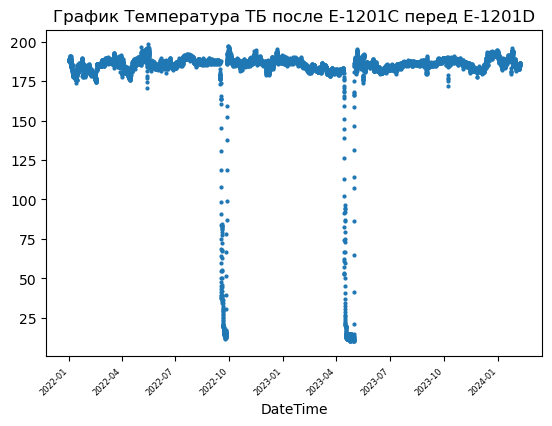

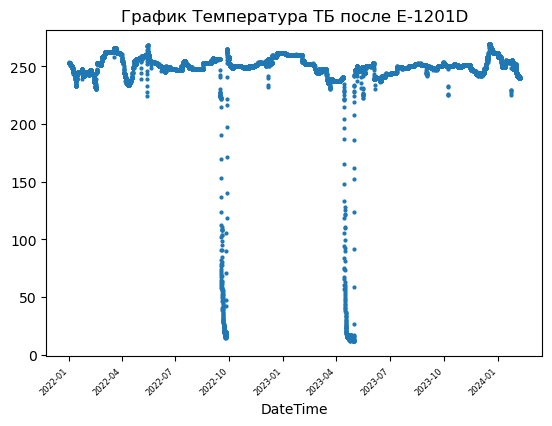

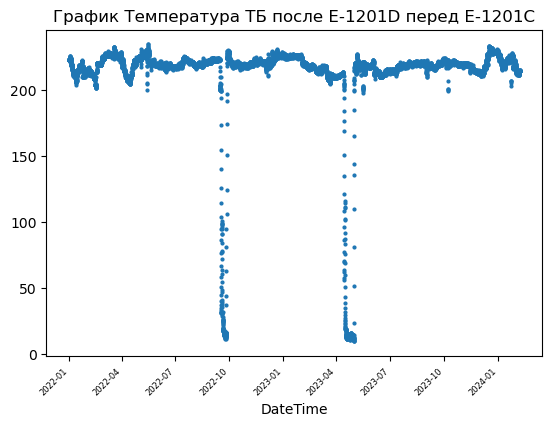

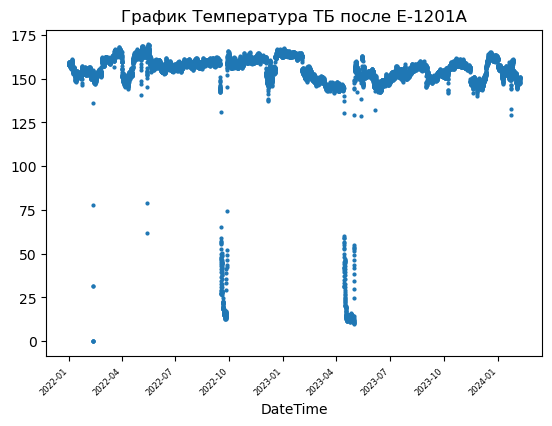

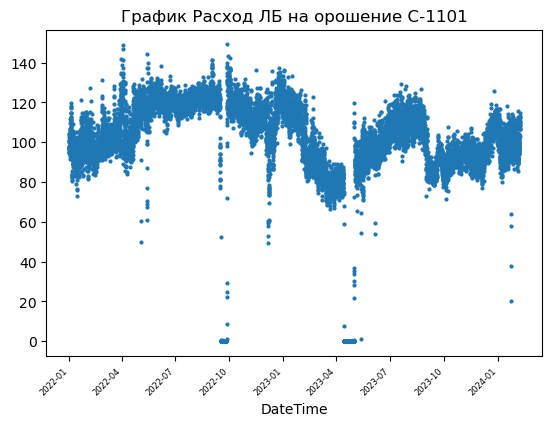

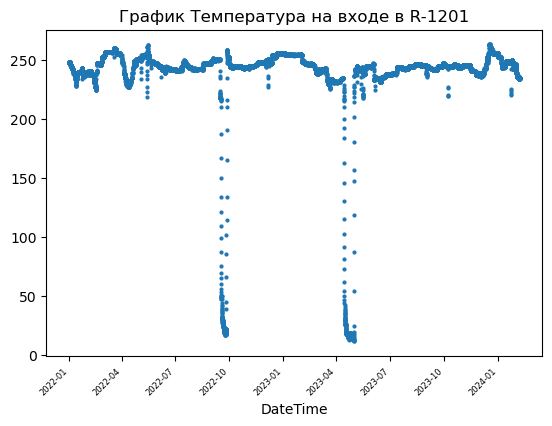

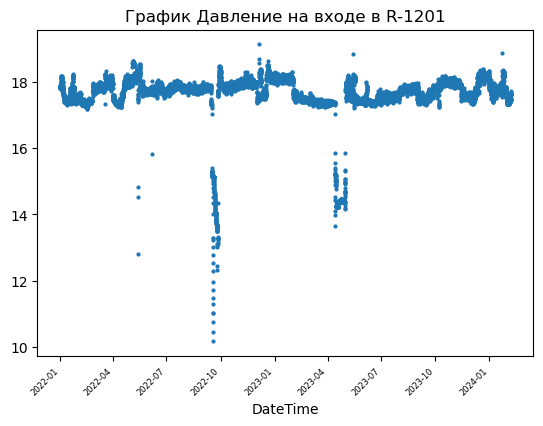

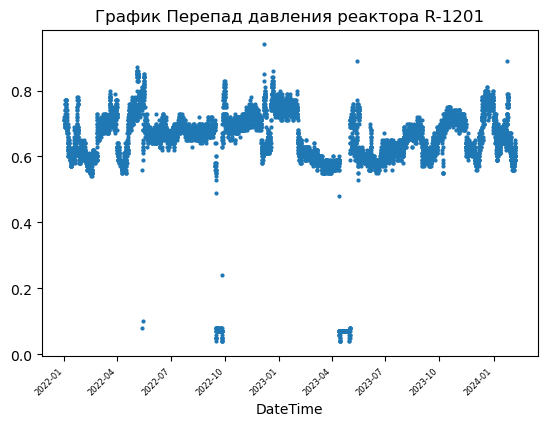

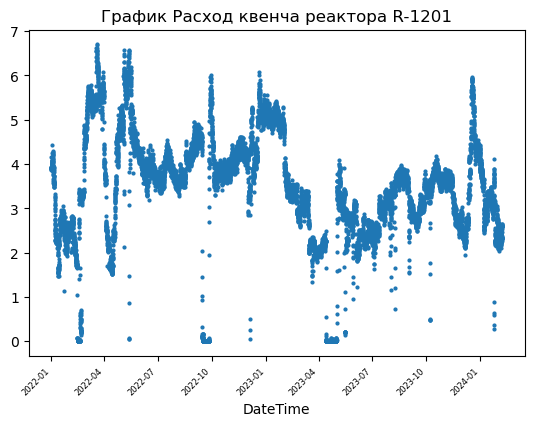

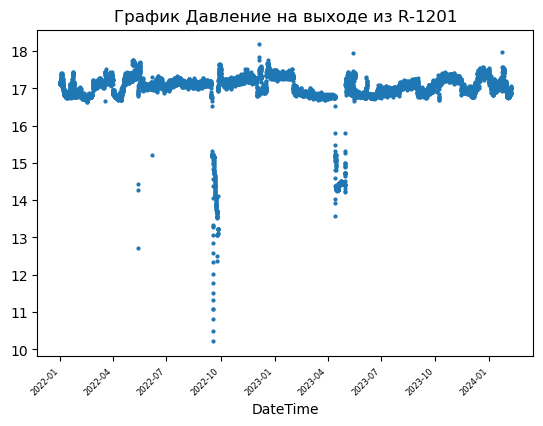

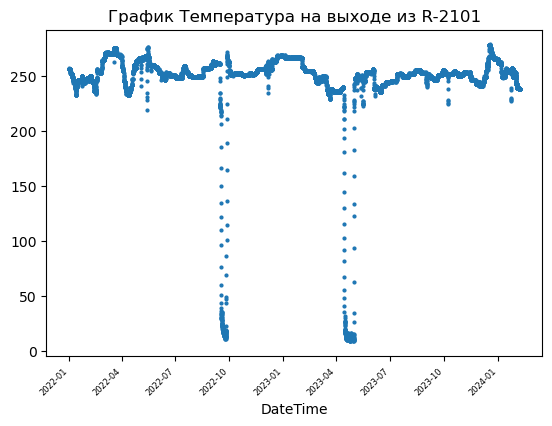

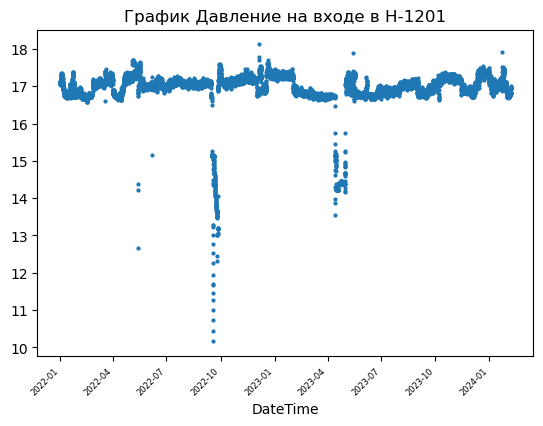

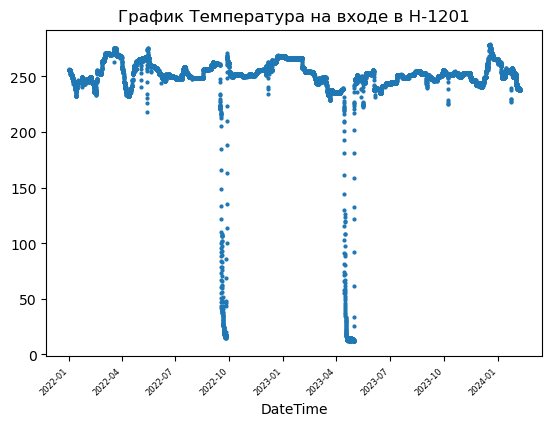

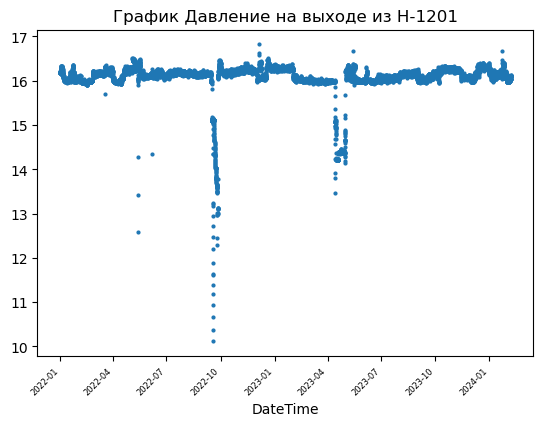

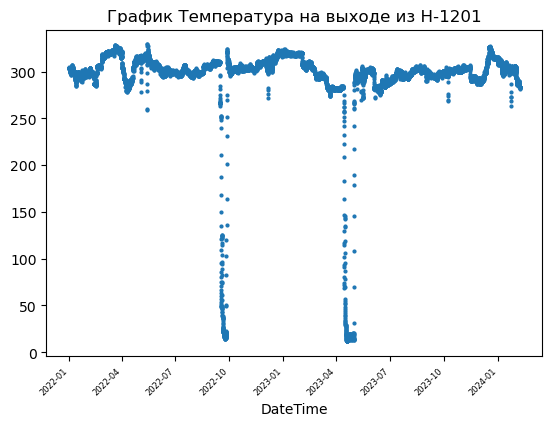

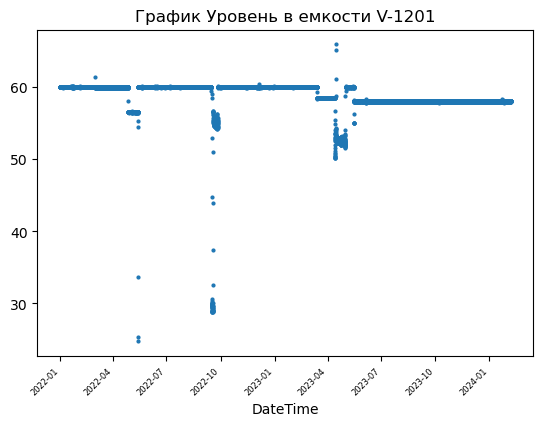

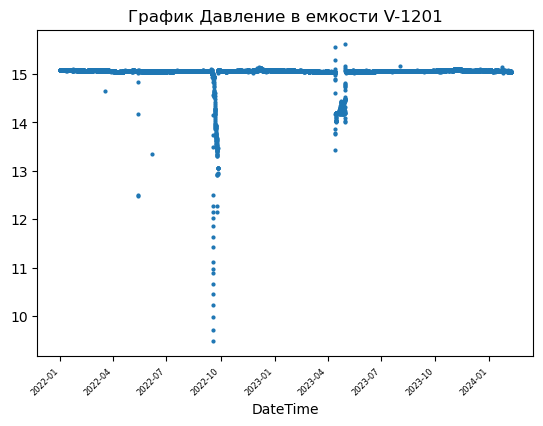

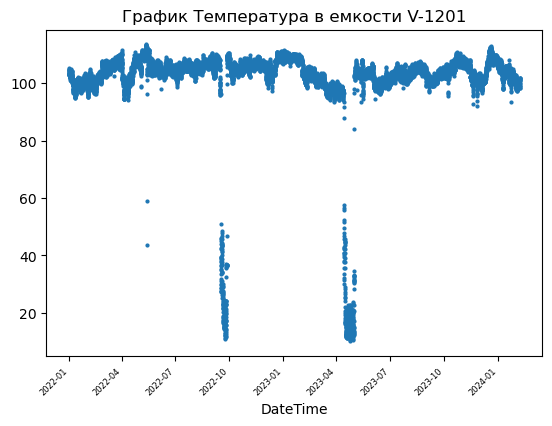

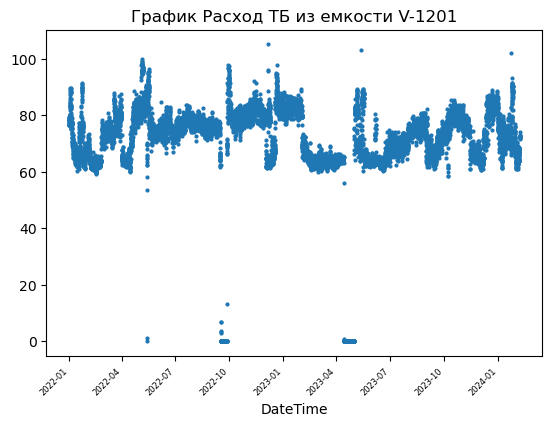

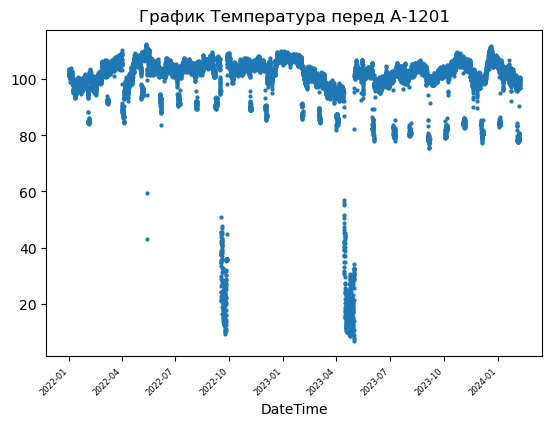

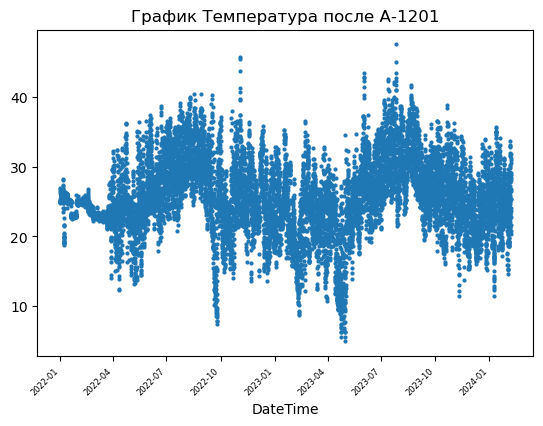

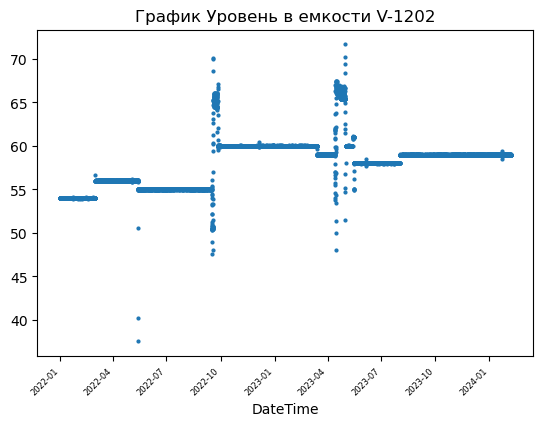

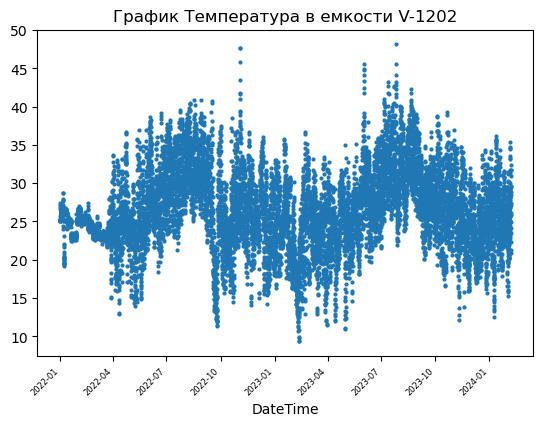

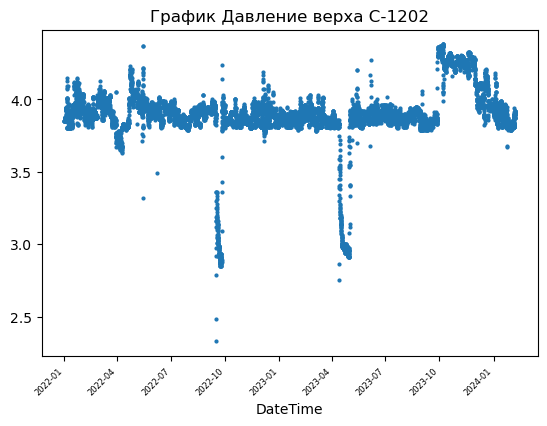

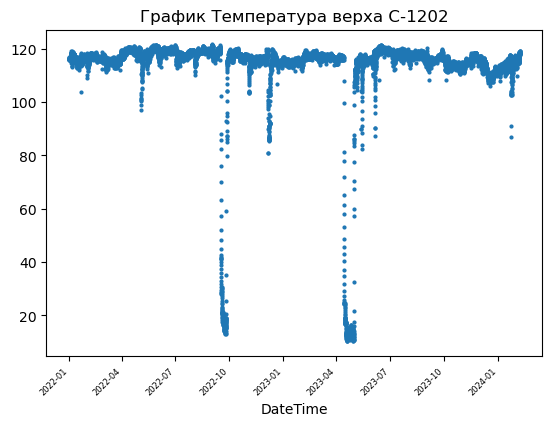

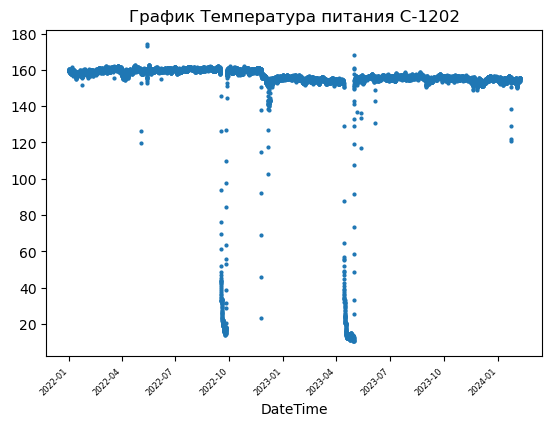

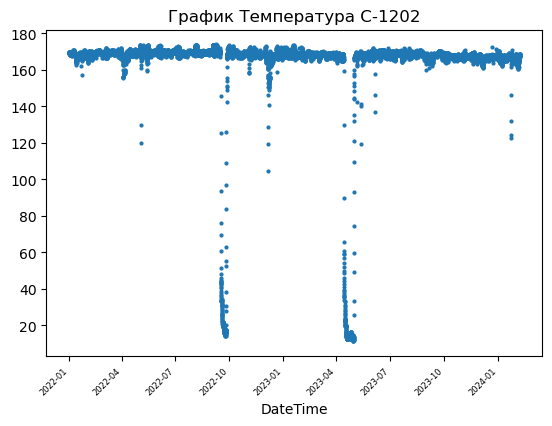

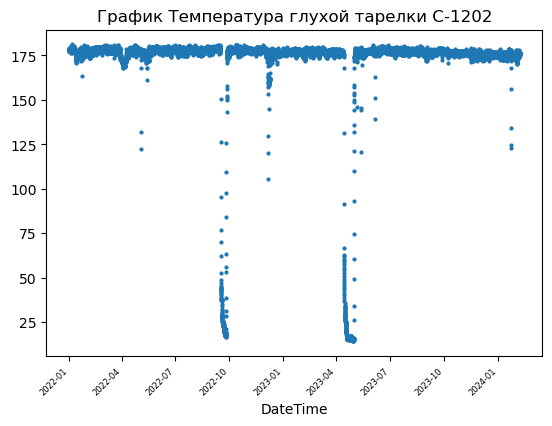

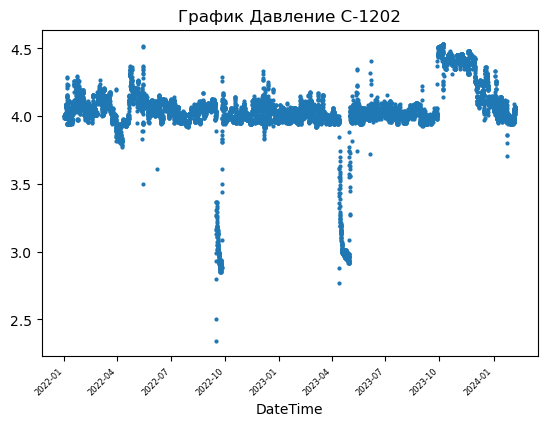

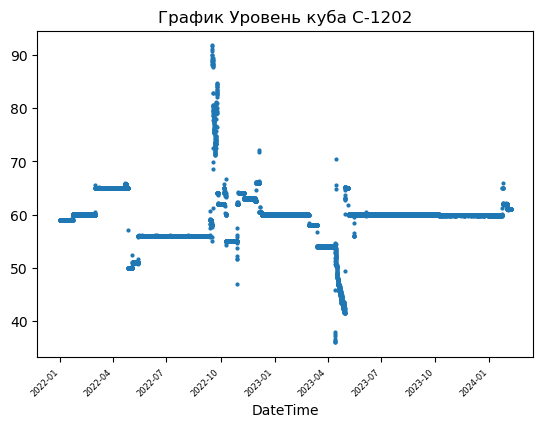

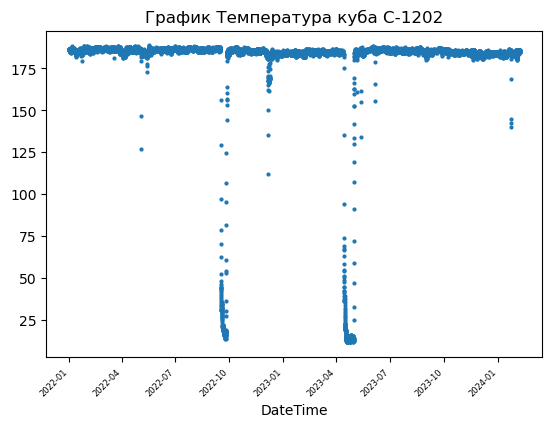

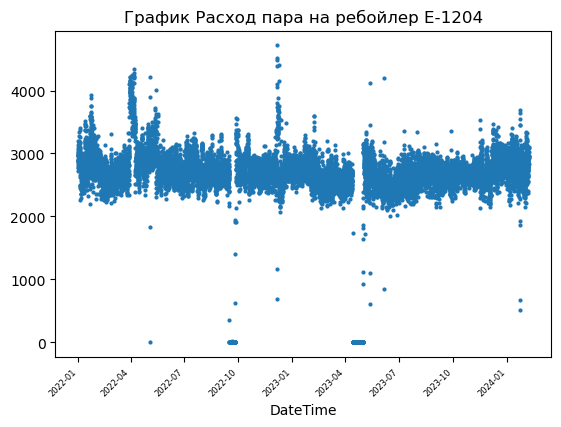

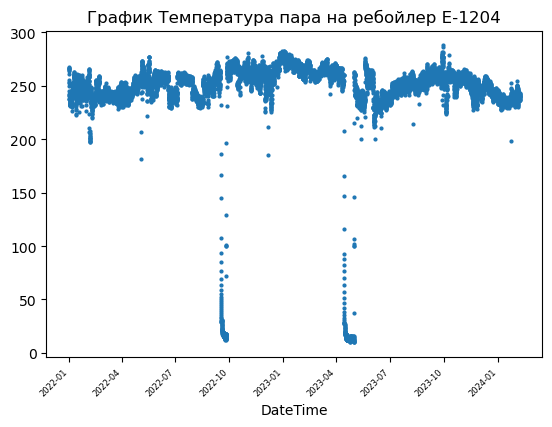

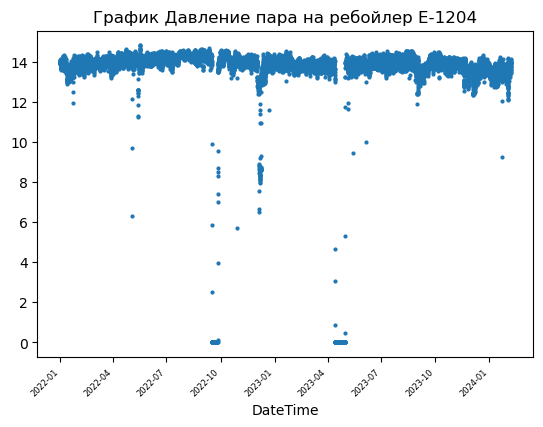

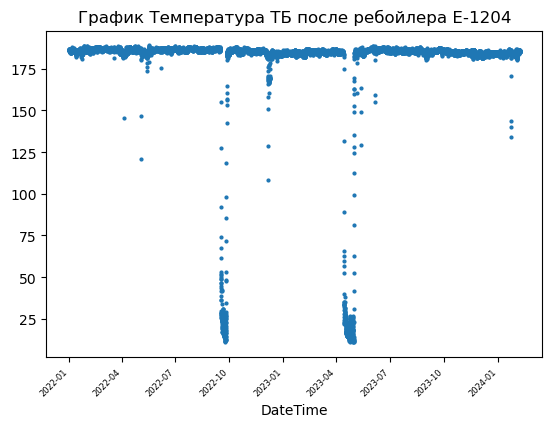

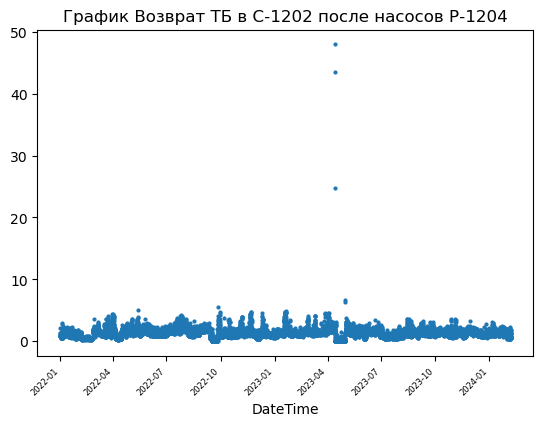

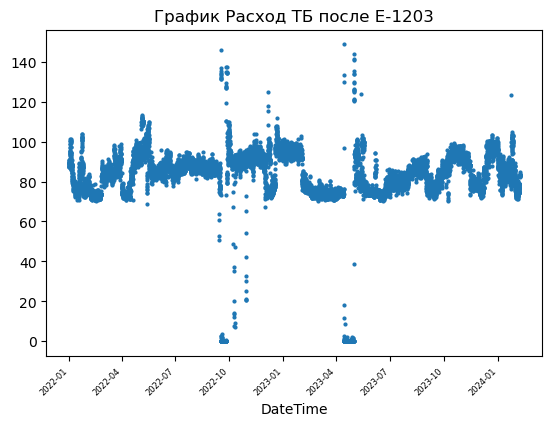

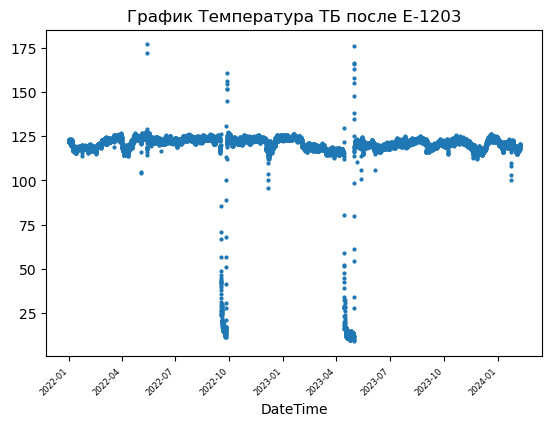

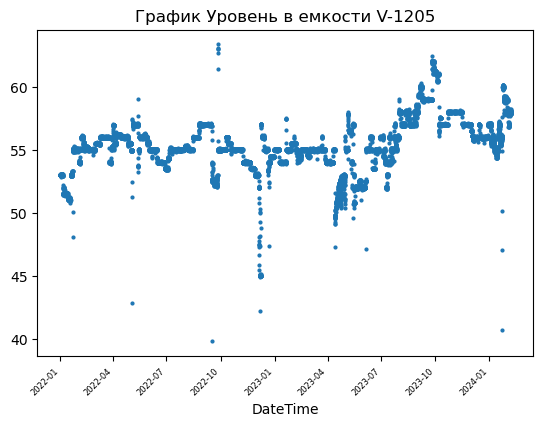

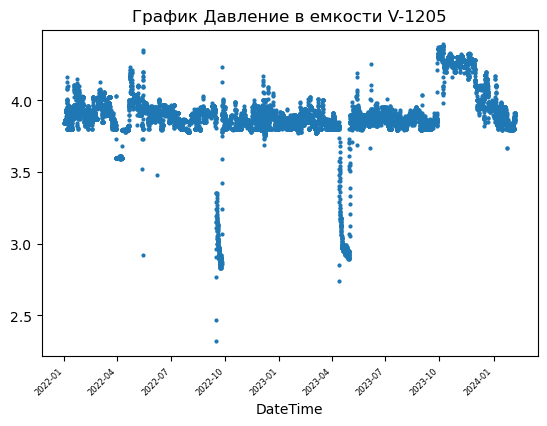

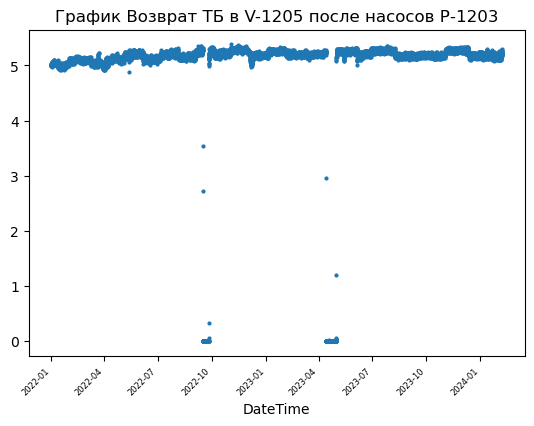

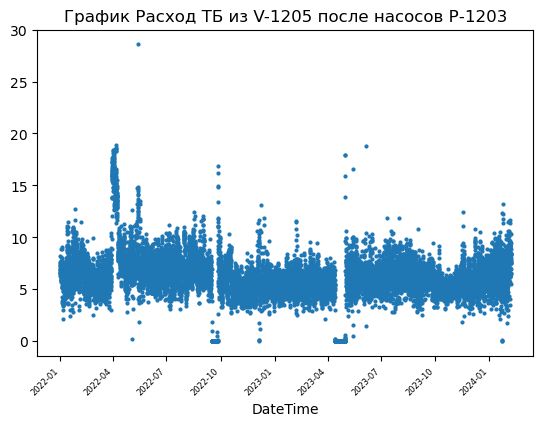

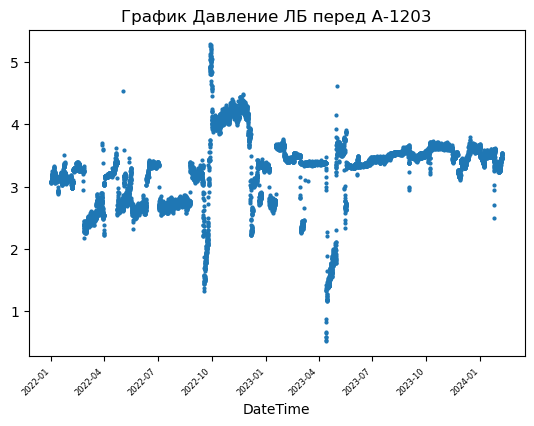

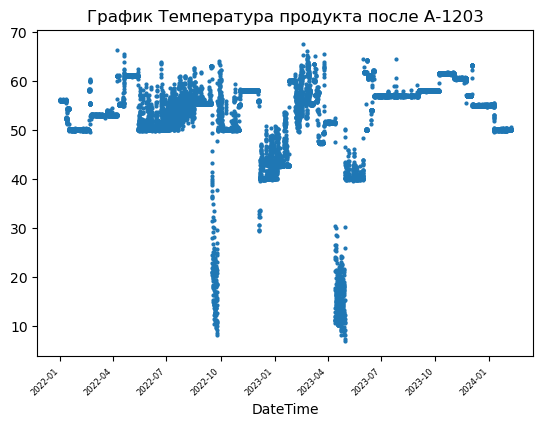

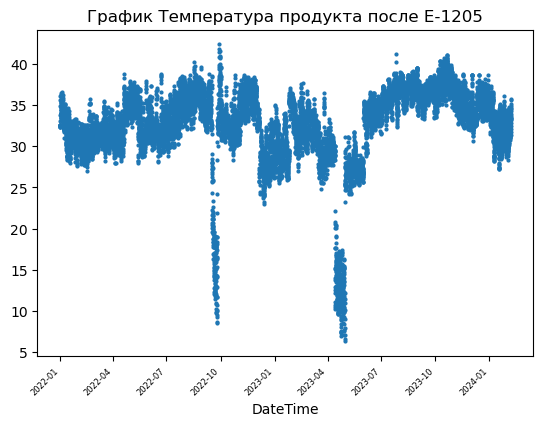

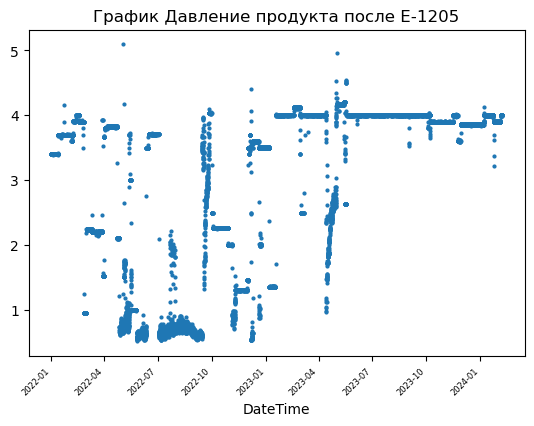

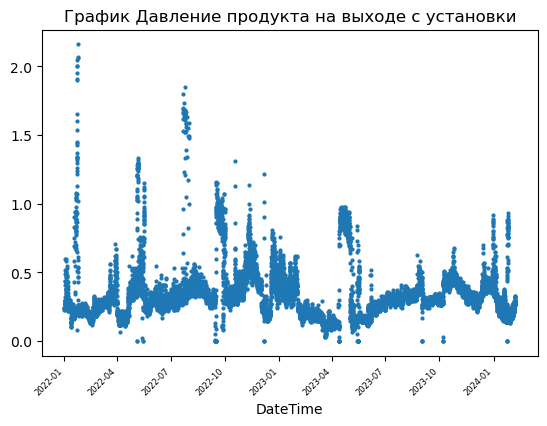

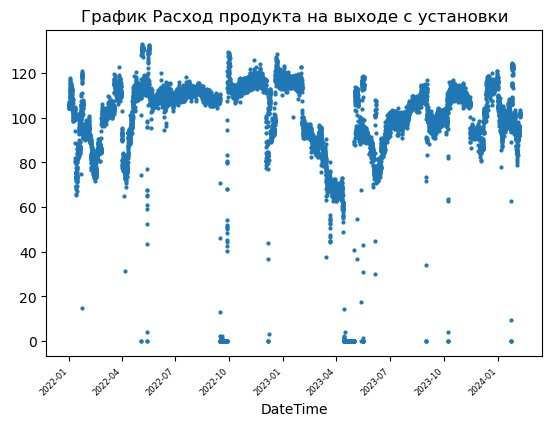

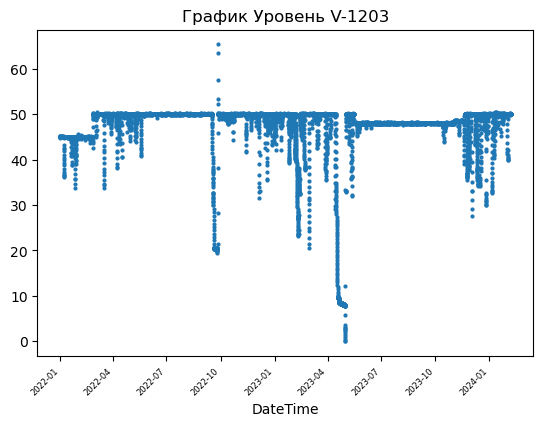

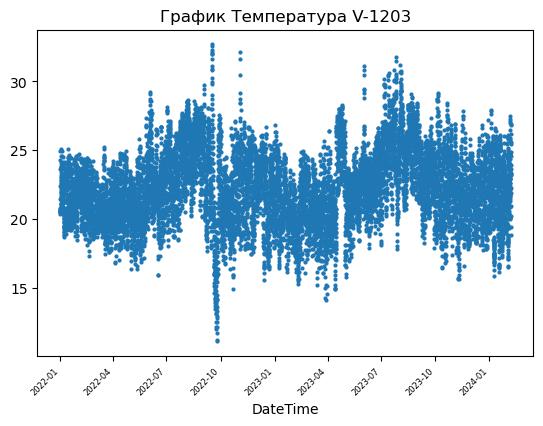

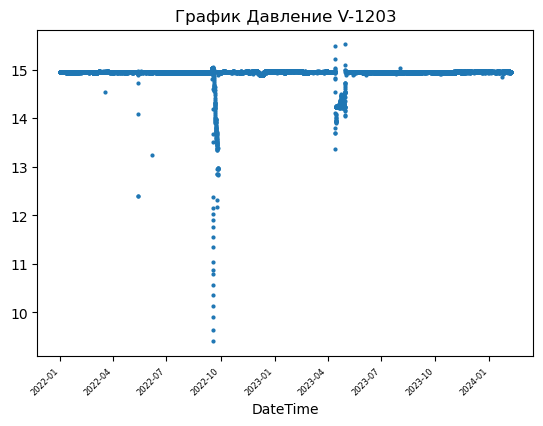

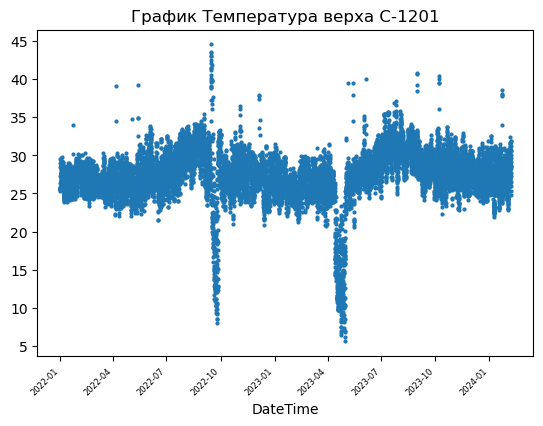

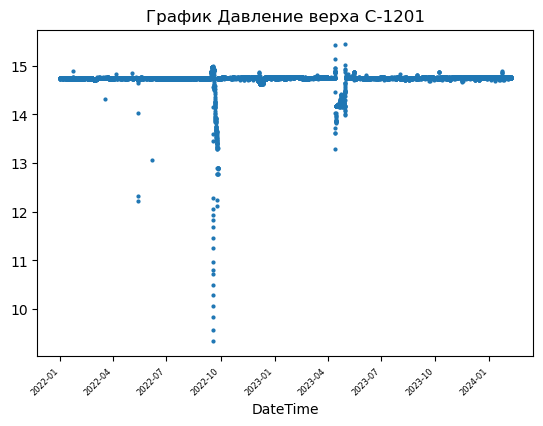

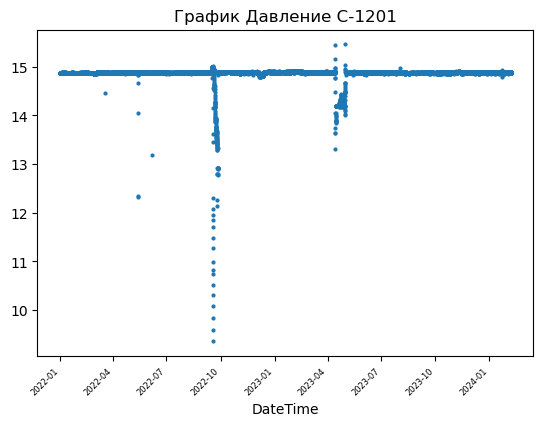

In [18]:
parameter_vis(df_X1)